In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import yasa
import seaborn as sns
import ghibtools as gh
import mne
import glob
import time
import datetime
import yasa
from scipy import signal
import json
from params import *

In [2]:
subject = 'S4'

In [3]:
data = xr.open_dataarray(f'../preproc/{subject}_reref.nc') # load preprocessed data (lazy load)

In [4]:
sig = data.sel(chan = 'Fp2').data

butter iirfilter of 4th-order
btype : bandpass


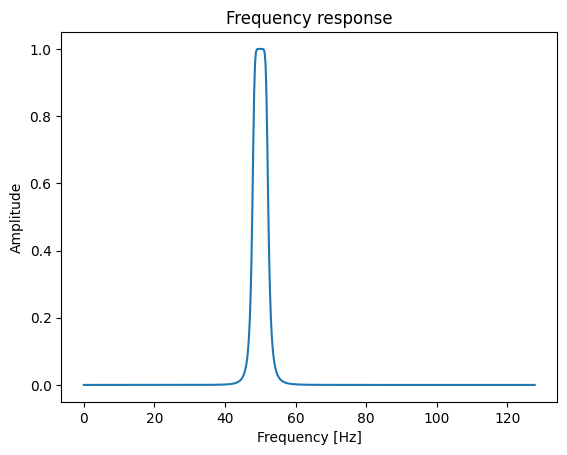

array([-0.05167957,  1.46482288,  0.99245232, ..., -0.00554558,
       -0.01124239, -0.00201876])

In [5]:
gh.iirfilt(sig, srate, lowcut = 48 , highcut = 52, verbose = True, show = True)

In [6]:
def complex_mw(time, n_cycles , freq, a= 1, m = 0): 
    """
    time : time vector of the wavelet
    n_cycles : number of cycles in the wavelet
    freq : frequency of the wavelet
    a : amplitude of the wavelet
    m : x center of the wavelet
    """
    s = n_cycles / (2 * np.pi * freq)
    GaussWin = a * np.exp( -(time - m)** 2 / (2 * s**2)) # real gaussian window
    complex_sinewave = np.exp(1j * 2 *np.pi * freq * time) # complex sinusoidal signal
    cmw = GaussWin * complex_sinewave
    return cmw

In [7]:
tmw = np.arange(-2,2,1/srate)
mw = complex_mw(tmw, n_cycles = 30, freq= 20)

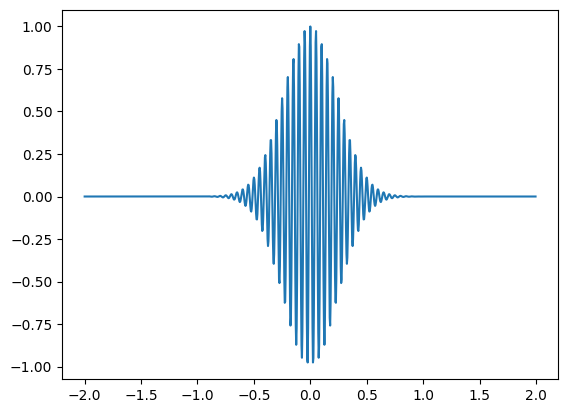

In [8]:
fig, ax = plt.subplots()
ax.plot(tmw, np.real(mw))

In [9]:
def morlet_family(srate, f_start, f_stop, n_step, n_cycles, show = False):
    tmw = np.arange(-20,20,1/srate)
    freqs = np.linspace(f_start,f_stop,n_step) 
    mw_family = np.zeros((freqs.size, tmw.size), dtype = 'complex')
    for i, fi in enumerate(freqs):
        mw_family[i,:] = complex_mw(tmw, n_cycles = n_cycles, freq = fi)
    if show:
        fig, ax = plt.subplots()
        im = ax.pcolormesh(tmw, freqs, np.real(mw_family))
        ax.set_ylabel('Freq [Hz]')
        ax.set_xlabel('Time')
        fig.colorbar(im)
        plt.show()
    return freqs, mw_family

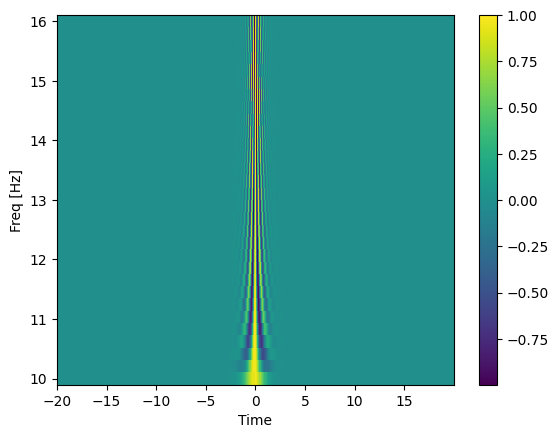

In [10]:
freq , family = morlet_family(srate, f_start = 10, f_stop = 16, n_step = 30, n_cycles = 50, show = True)

In [11]:
t_target = 10000
delta = 15
t_start = t_target - delta
t_stop = t_target + delta
sig = data.sel(chan = 'Fp2', time = slice(t_start,t_stop)).data

In [12]:
def compute_tf(sig, srate, f_start, f_stop, n_step, n_cycles):
    freqs, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles)
    tf = np.zeros((family.shape[0], sig.size), dtype = 'complex')
    for i in range(family.shape[0]):
        mw = family[i,:]
        tf[i,:] = signal.fftconvolve(sig, mw, mode = 'same')
    return freqs , np.abs(tf)

In [13]:
def compute_tf_fast(sig, srate, f_start, f_stop, n_step, n_cycles, feature = 'module', exponent = 1):
    freqs, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles)
    tf = np.zeros((family.shape[0], sig.size), dtype = 'complex')
    sigs = np.tile(sig, (n_step,1))
    tf = signal.fftconvolve(sigs, family, mode = 'same', axes = 1)
    if feature == 'module':
        return freqs , np.abs(tf) ** exponent
    elif feature == 'real':
        return freqs , np.real(tf) ** exponent

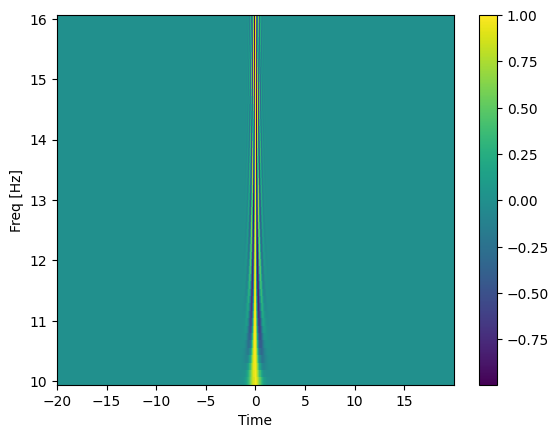

In [14]:
f_start = 10
f_stop = 16
n_step = 50
n_cycles = 30
freq, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles, show = True)
f_fast = np.linspace(f_start,f_stop,n_step) 
t = np.arange(0, sig.size/srate, 1 / srate)

tf_fast = np.zeros((family.shape[0], sig.size), dtype = 'complex')
for i in range(family.shape[0]):
    mw = family[i,:]
    tf_fast[i,:] = signal.fftconvolve(sig, mw, mode = 'same', axes = 0)

0.05719042499549687
srate down 51.2
0.009921163087710738
ratio duration 5.76448794258187


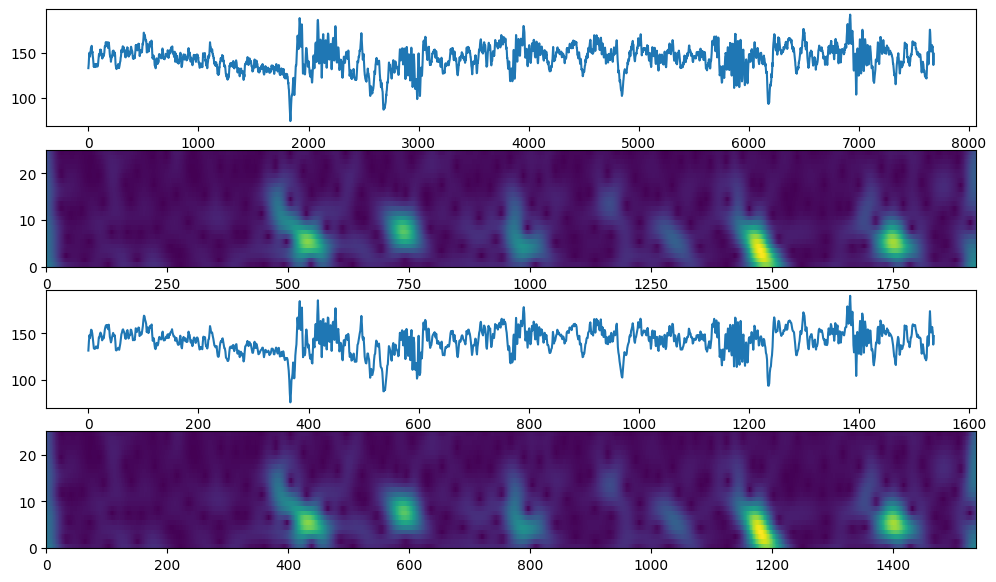

In [15]:
fig, axs = plt.subplots(nrows = 4, figsize = (12,7))
ax = axs[0]
ax.plot(sig)
ax = axs[1]
t1 = time.perf_counter()
f, tf = compute_tf_fast(sig, srate, f_start=10 , f_stop = 16 , n_step = 25, n_cycles = 20)
t2 = time.perf_counter()
duration_full = t2 - t1
print(duration_full)
ax.pcolormesh(signal.decimate(tf, q=4))

factor = 5
srate_down = srate / factor
sig_decimate = signal.decimate(sig, q=factor)
ax = axs[2]
ax.plot(sig_decimate)
ax = axs[3]
t1 = time.perf_counter()
f, tf = compute_tf_fast(sig_decimate, srate_down, f_start=10 , f_stop = 16 , n_step = 25, n_cycles = 20)
print('srate down', srate_down)
t2 = time.perf_counter()
duration_down = t2 - t1
print(duration_down)
ratio_duration = duration_full / duration_down
print('ratio duration', ratio_duration)
ax.pcolormesh(tf)


In [16]:
t_target = 10060
delta = 15
t_start = t_target - delta
t_stop = t_target + delta
ind_start = int(t_start * srate)
ind_stop = int(t_stop * srate)
# sig = data.sel(chan = 'Fp1', time = slice(t_start,t_stop)).data
sig = data[0,ind_start:ind_stop].data

marker_t = 4434.9

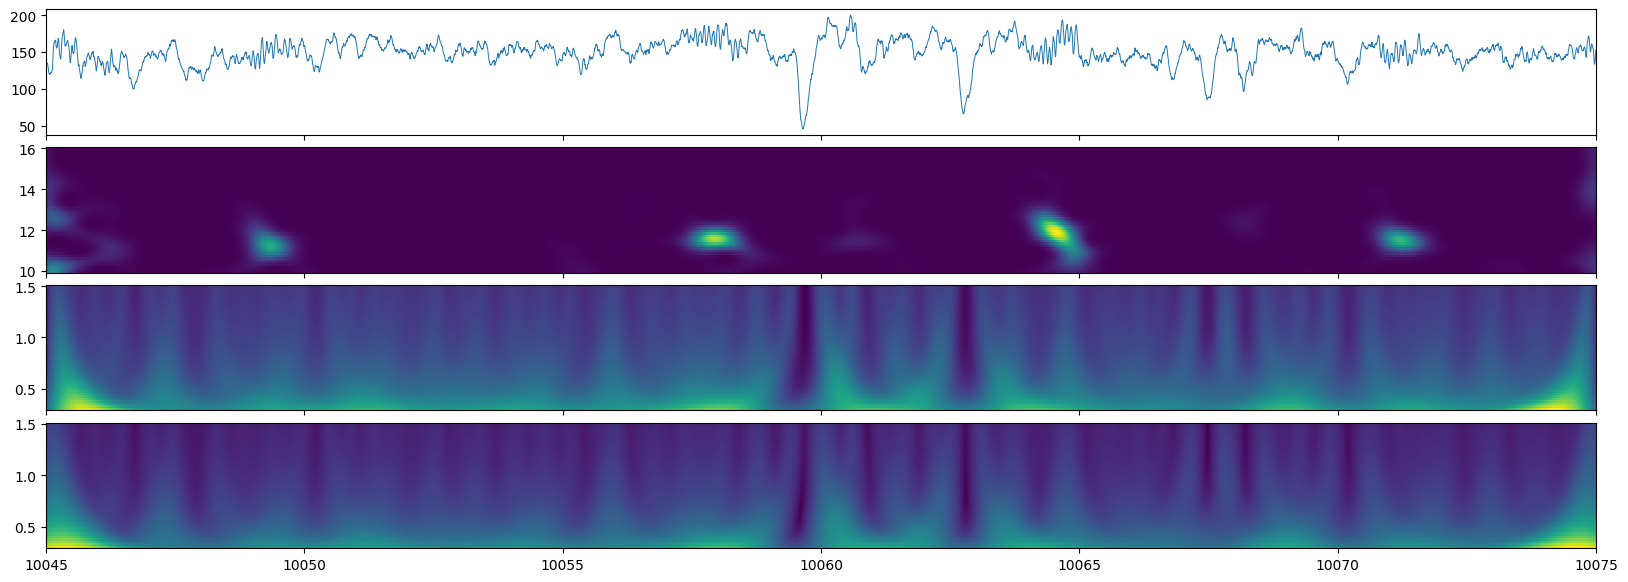

In [17]:
fig, axs = plt.subplots(nrows = 4, figsize = (20,7), sharex = True)
fig.subplots_adjust(hspace = 0.1)

t = np.arange(t_start, t_stop, 1 /srate)

ax = axs[0]
ax.plot(t,sig, lw = 0.7)
ax.set_xlim(t_start, t_stop)
ax.axvline(x = marker_t, color = 'r')

ax = axs[1]
f, tf = compute_tf_fast(sig, srate, f_start=10 , f_stop = 16 , n_step = 50, n_cycles = 25, feature = 'module', exponent = 3)
ax.pcolormesh(t, f , tf)

ax = axs[2]
f, tf = compute_tf_fast(sig, srate, f_start=0.3 , f_stop = 1.5 , n_step = 50, n_cycles = 2, feature = 'real', exponent = 1)
ax.pcolormesh(t,f,tf)

ax = axs[3]
f, tf = compute_tf_fast(sig, srate, f_start=0.3 , f_stop = 1.5 , n_step = 50, n_cycles = 2, feature = 'module', exponent = 1)
ax.pcolormesh(t,f,tf)

In [24]:
def rms(x):
    """Fast root mean square."""
    n = x.size
    ms = 0
    for i in range(n):
        ms += x[i] ** 2
    ms /= n
    return np.sqrt(ms)

In [35]:
out.size

300

In [42]:
t, out = yasa.moving_transform(sig, sf = srate, method = 'rms', interp = True)

In [43]:
t.shape

(7680,)

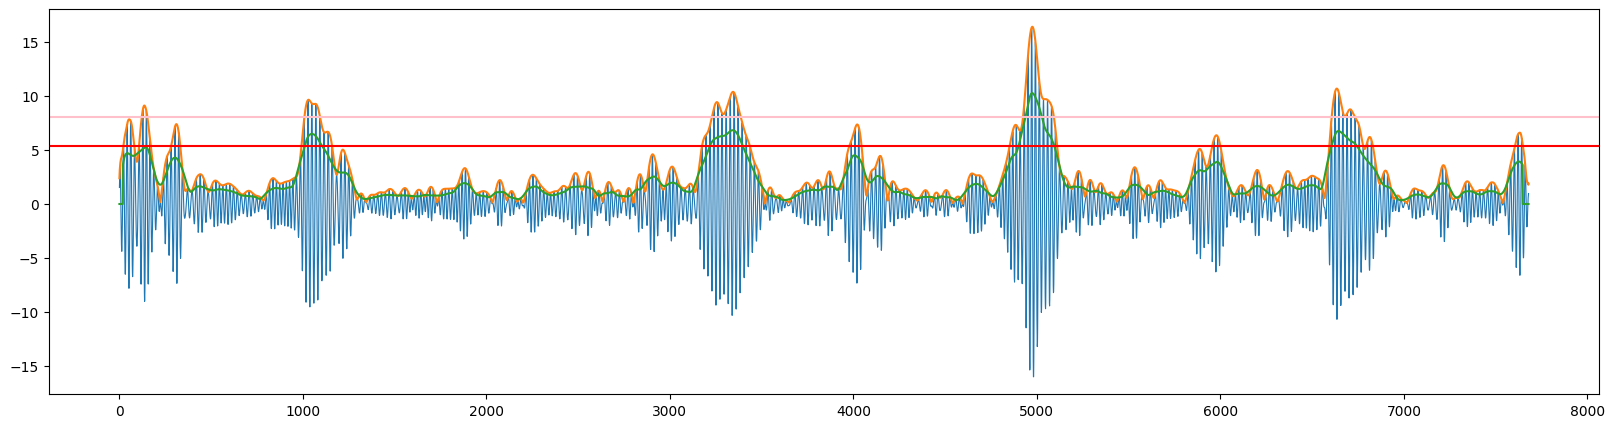

In [56]:
sigma = gh.iirfilt(sig, srate, 11,16)
sigma_env = gh.get_amp(sigma)
t, out = yasa.moving_transform(sigma, sf = srate, method = 'rms', interp = True)

fig, ax = plt.subplots(figsize = (20,5))
ax.plot(sigma, lw = 0.8)
ax.plot(sigma_env)
ax.plot(out)
ax.axhline(y = np.std(out) * 3, color = 'r')
ax.axhline(y = gh.mad(sigma) * 5, color = 'pink')

In [69]:
test_sig = data.loc['Fz',:].values
sigma_test = gh.iirfilt(test_sig, srate, 11 ,16)
sigma_env_test = gh.get_amp(sigma_test)
t, rms = yasa.moving_transform(sigma_test, sf = srate, method = 'rms', interp = True)

In [73]:
broad_sig =  gh.iirfilt(test_sig, srate, 1 ,30)

In [74]:
t, corr =  yasa.moving_transform(x = sigma_test, y = broad_sig, sf = srate, method = 'corr', interp = True)

In [65]:
%matplotlib widget

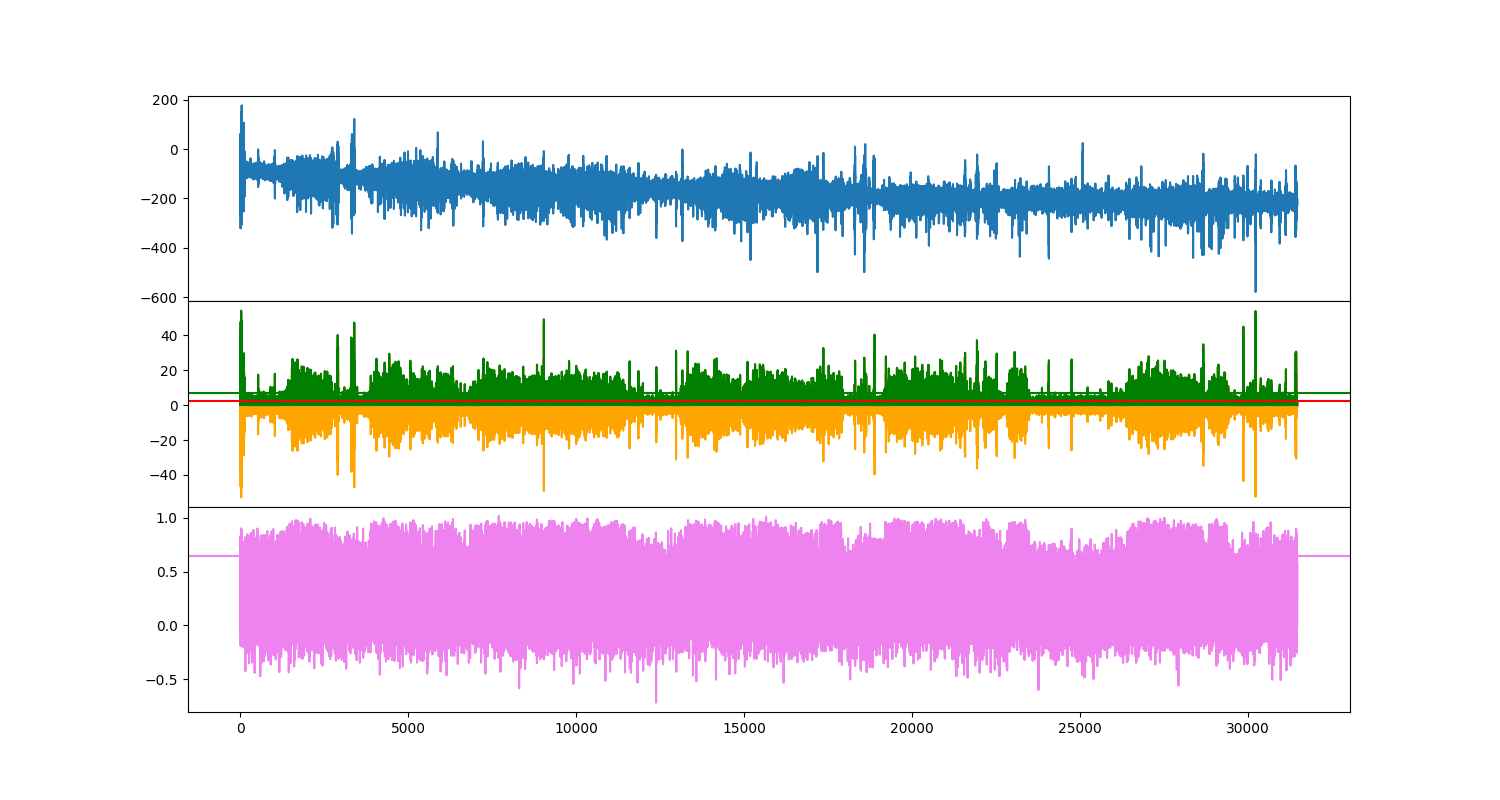

In [82]:
fig, axs = plt.subplots(nrows = 3, figsize = (15,8), sharex = True)
fig.subplots_adjust(hspace = 0)


ax = axs[0]
ax.plot(t, test_sig, color = 'tab:blue')

ax = axs[1]
ax.plot(t, sigma_test, color = 'orange')
ax.plot(t, rms, color = 'red')
ax.plot(t, sigma_env_test, color = 'g')
ax.axhline(np.std(rms) * 1.5, color = 'r')
ax.axhline(gh.mad(sigma_env_test) * 5, color = 'g')

ax = axs[2]
ax.plot(t, corr, color = 'violet')
ax.axhline(0.65 , color = 'violet')


In [43]:
sigma = gh.iirfilt(sig, srate, 11 , 16, show = False)
env = gh.get_amp(sigma)
mad = gh.mad(env)

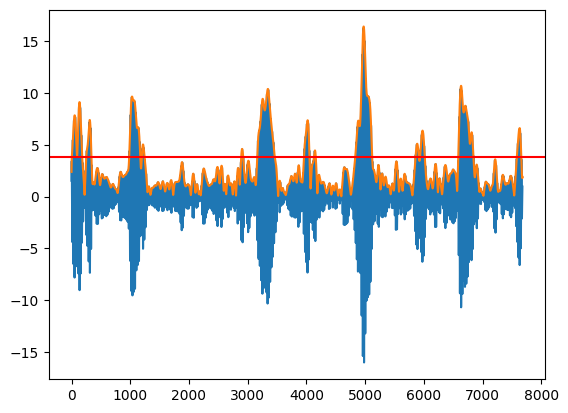

In [49]:
fig, ax = plt.subplots()
# ax.plot(sig)
ax.plot(sigma)
ax.plot(env)
ax.axhline(y = mad  * 3, color = 'red')

In [123]:
def get_sigma_env(sig, srate, lowcut = 11, highcut = 16):
    sigma = gh.iirfilt(sig, srate, lowcut, highcut)
    sigma_env = gh.get_amp(sigma)
    return sigma_env

In [129]:
def detect_sigma_bursts(env, n_mads):
    rises, = np.where((env[:-1] <=n_mads) & (env[1:] >n_mads)) # detect where crossing n_mads but rising
    decays, = np.where((env[:-1] >=n_mads) & (env[1:] <n_mads)) # detect where crossing n_mads but decaying
    if rises[0] > decays[0]: # first point detected has to be a rise
        decays = decays[1:] # so remove the first decay if is before first rise
    if rises[-1] > decays[-1]: # last point detected has to be a decay
        rises = rises[:-1] # so remove the last rise if is after last decay

    return pd.DataFrame.from_dict({'rises':rises, 'decays':decays}, orient = 'index').T

In [134]:
def compute_sigma_bursts_features(sigma_env, sigma_bursts, srate):
    features = []
    for i , row in sigma_bursts.iterrows(): # last cycle is probably not complete so it is removed in any case
        if i != sigma_bursts.index[-1]:
            
            start_ind = int(row['rises'])
            stop_ind = int(row['decays'])
            
            start_t = start_ind / srate
            stop_t = stop_ind / srate
            
            burst_duration = stop_t - start_t
            peak_ind, = np.nonzero(sigma_env == np.max(sigma_env[start_ind:stop_ind]))[0]
            peak_t = peak_ind / srate
            
            features.append([start_ind, stop_ind, start_t, stop_t, burst_duration,peak_ind, peak_t])
    df_features = pd.DataFrame(features, columns = ['start_ind','stop_ind','start_t','stop_t','burst_duration','peak_ind','peak_t'])
    return df_features     

In [135]:
def clean_bursts(burst_features, min_duration=0.5, max_duration=3):
    return burst_features[(burst_features['burst_duration'] > min_duration) & (burst_features['burst_duration'] < max_duration)].reset_index(drop = True)

In [148]:
def detect_spindles(sig, srate, n_mads=5, sigma_low=11, sigma_high=16, min_duration=0.5, max_duration = 3):
    sigma_env = get_sigma_env(sig, srate, sigma_low, sigma_high)
    sigma_bursts = detect_sigma_bursts(sigma_env, n_mads)
    sigma_bursts_features = compute_sigma_bursts_features(sigma_env, sigma_bursts, srate)
    clean_sigma_bursts_features = clean_bursts(sigma_bursts_features, min_duration=min_duration, max_duration=max_duration)
    return clean_sigma_bursts_features

In [161]:
data

<xarray.DataArray (chan: 19, time: 8057600)>
[153094400 values with dtype=float64]
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 3.147e+04 3.147e+04
  * chan     (chan) object 'Fp2' 'Cz' 'C4' 'T4' ... 'THERM' 'EOGDt-A1' 'EOGG-A2'
Attributes:
    unit:     uV
    srate:    256.0

In [169]:
def eeg_da_spindles(da, srate, n_mads=5, sigma_low=11, sigma_high=16, min_duration=0.5, max_duration = 3, computing_chans = None, verbose=False):
    chan_spindles_concat = []
    if computing_chans is None:
        chans = da.coords['chan'].values
    else:
        chans = computing_chans
    for chan in chans:
        if verbose:
            print(chan)
        sig = da.loc[chan,:].data
        spindles = detect_spindles(sig, srate, n_mads, sigma_low, sigma_high, min_duration, max_duration)
        spindles['channel'] = chan
        chan_spindles_concat.append(spindles)
    return pd.concat(chan_spindles_concat)

In [170]:
all_spindles = eeg_da_spindles(data, srate, computing_chans = sigma_power_chans, verbose = True)

Fp2
Fp1
Fz
C4
C3
Cz


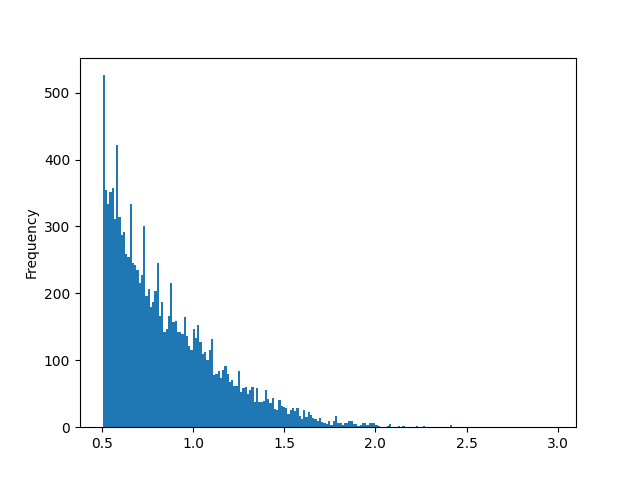

In [181]:
plt.figure()
all_spindles['burst_duration'].plot.hist(bins = 200)
plt.show()

In [171]:
rsp_features = pd.read_excel('/crnldata/cmo/Etudiants/NBuonviso2022_Sleep_EEG_Respi_Valentin/resp_features/S4_resp_features_tagged.xlsx', index_col = 0)

In [182]:
def crosscorrelogram(a,b):
    """
    Compute combinatorial difference between a vs b (a - b with all possibilities)
    
    ------------------
    INPUTS :
    a : 1D numpy vector
    b : 1D numpy vector
    
    OUTPUT :
    c : crosscorrelogram vector of shape (a.size*b.size,)
    
    """
    c = a[:, np.newaxis] - b[np.newaxis, :]
    return c.reshape(-1)

In [183]:
cross_co = crosscorrelogram(all_spindles[all_spindles['channel'] == 'Fz']['start_t'].values, rsp_features['start_time'].values)

In [186]:
cross_co

array([ -4.09765625,  -5.31640625,  -8.0625    , ..., -12.98828125,
       -17.39453125, -25.484375  ])

In [187]:
%matplotlib inline

In [206]:
all_spindles

,start_ind,stop_ind,start_t,stop_t,burst_duration,peak_ind,peak_t,channel
0,297,770,1.160156,3.007812,1.847656,572,2.234375,Fp2
1,1015,1303,3.964844,5.089844,1.125000,1171,4.574219,Fp2
2,1494,1740,5.835938,6.796875,0.960938,1549,6.050781,Fp2
3,1870,2403,7.304688,9.386719,2.082031,1968,7.687500,Fp2
4,2422,2556,9.460938,9.984375,0.523438,2497,9.753906,Fp2
...,...,...,...,...,...,...,...,...
2335,8043072,8043222,31418.250000,31418.835938,0.585938,8043173,31418.644531,Cz
2336,8044645,8044856,31424.394531,31425.218750,0.824219,8044814,31425.054688,Cz
2337,8045673,8045872,31428.410156,31429.187500,0.777344,8045738,31428.664062,Cz
2338,8045890,8046117,31429.257812,31430.144531,0.886719,8045966,31429.554688,Cz


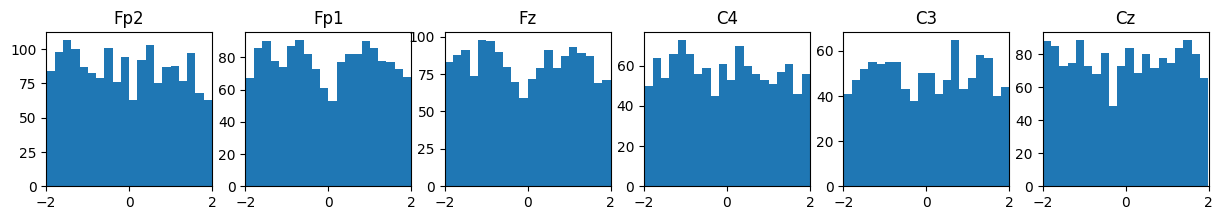

In [235]:
delta = 2
delta_t_by_bin = 0.2
nbins = int(delta * 2 / delta_t_by_bin)
fig, axs = plt.subplots(ncols = len(sigma_power_chans), figsize = (15,2))
for c, chan in enumerate(sigma_power_chans):
    ax = axs[c]
    cross_co = crosscorrelogram(all_spindles[all_spindles['channel'] == chan]['start_t'].values, rsp_features['stop_time'].values)
    cross_sel = cross_co[(cross_co < delta) & (cross_co > -delta)]
    ax.hist(cross_sel, bins = nbins, align = 'mid')
    ax.set_title(chan)
    ax.set_xlim(-delta,delta)
plt.show()

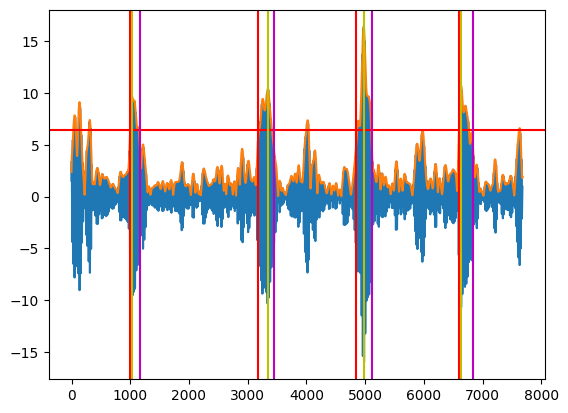

In [151]:
fig, ax = plt.subplots()
# ax.plot(sig)
ax.plot(sigma)
ax.plot(env)
ax.axhline(y = mad  * n_mads, color = 'red')
for i, row in spindles.iterrows():
    ax.axvline(x = row['start_ind'], color = 'r')
    ax.axvline(x = row['stop_ind'], color = 'm')
    ax.axvline(x = row['peak_ind'], color = 'y')

In [152]:
test_sig = data.loc['Fz',:].values

In [153]:
spindles = detect_spindles(test_sig, srate)

In [154]:
spindles

,start_ind,stop_ind,start_t,stop_t,burst_duration,peak_ind,peak_t
0,305,810,1.191406,3.164062,1.972656,572,2.234375
1,1019,1297,3.980469,5.066406,1.085938,1179,4.605469
2,1495,1839,5.839844,7.183594,1.343750,1549,6.050781
3,1911,2403,7.464844,9.386719,1.921875,1967,7.683594
4,2424,2768,9.468750,10.812500,1.343750,2606,10.179688
...,...,...,...,...,...,...,...
2421,7970592,7970771,31135.125000,31135.824219,0.699219,7970657,31135.378906
2422,7971389,7971526,31138.238281,31138.773438,0.535156,7971417,31138.347656
2423,7971908,7972137,31140.265625,31141.160156,0.894531,7972050,31140.820312
2424,8045883,8046043,31429.230469,31429.855469,0.625000,8045962,31429.539062


<AxesSubplot: ylabel='Frequency'>

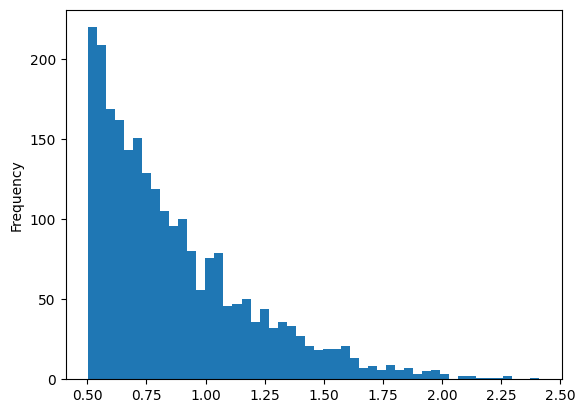

In [157]:
spindles['burst_duration'].plot.hist(bins = 50)

In [158]:
%matplotlib widget

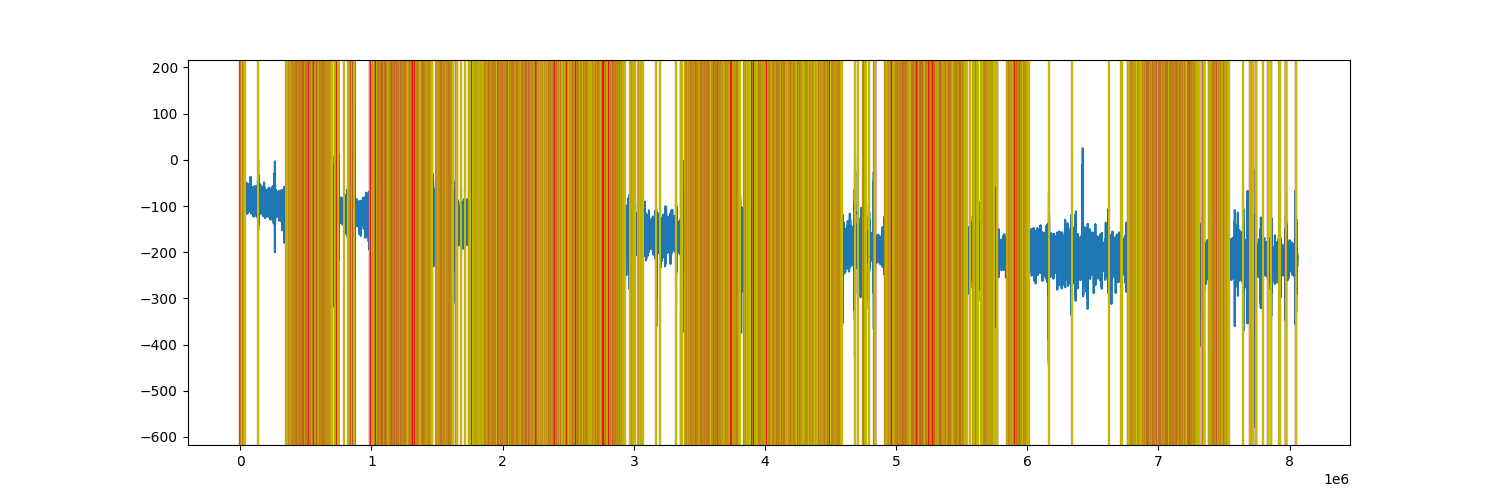

In [160]:
fig, ax = plt.subplots(figsize = (15,5))
# ax.plot(sig)
ax.plot(test_sig)
# ax.axhline(y = mad  * 5, color = 'red')
for i, row in spindles.iterrows():
    ax.axvline(x = row['start_ind'], color = 'r')
    ax.axvline(x = row['stop_ind'], color = 'm')
    ax.axvline(x = row['peak_ind'], color = 'y')

In [68]:
crossings

,rises,decays
0,18,83
1,104,173
2,275,333
3,989,1161
4,1214,1220
5,3171,3441
6,3971,4046
7,4847,5112
8,5879,5893
9,5950,6003


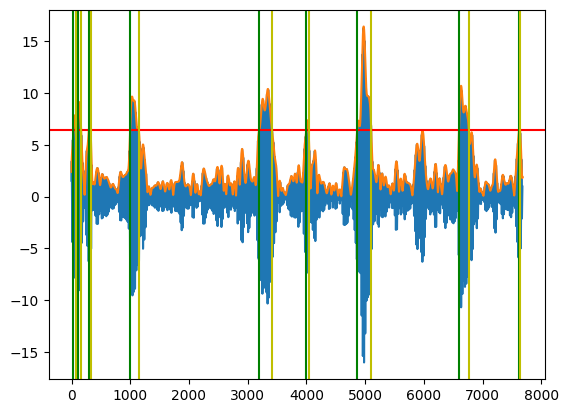

In [64]:
n_mads = 5
fig, ax = plt.subplots()
# ax.plot(sig)
ax.plot(sigma)
ax.plot(env)

rises, = np.where((env[:-1] <=mad * n_mads) & (env[1:] > mad * n_mads)) # detect where sign inversion from - to +
decays, = np.where((env[:-1] >=mad * n_mads) & (env[1:] < mad * n_mads)) # detect where sign inversion from + to -
ax.axhline(y = mad  * n_mads, color = 'red')
for rise in rises:
    ax.axvline(x = rise, color = 'g')
for decay in decays:
    ax.axvline(x = decay, color = 'y')

In [55]:
inds = np.nonzero(env > 3 * mad)[0]

In [57]:
inds.shape

(1708,)

In [37]:
mad = gh.mad(env**2)

In [38]:
mad

3.8006675288474296

In [27]:
spindles = pd.read_excel(f'../event_detection/{subject}_spindles_reref_yasa.xlsx', index_col = 0)

In [17]:
spindles

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter
0,15.160156,15.910156,16.777344,1.617188,76.690796,14.541233,1.512471,0.058145,12.064345,16,0.462651,0,Fp2,0,W
1,22.515625,23.867188,24.289062,1.773438,77.093320,15.279712,1.575529,0.067565,11.343477,19,0.760440,0,Fp2,0,W
2,54.046875,54.343750,54.792969,0.746094,52.904826,11.853407,1.707664,0.080165,11.542135,9,0.395833,0,Fp2,0,W
3,65.800781,66.808594,67.613281,1.812500,150.039012,24.185366,1.568414,0.036664,12.304631,18,0.554839,0,Fp2,0,W
4,68.812500,69.324219,69.476562,0.664062,61.455435,14.984043,1.920190,0.090785,11.094523,7,0.766082,0,Fp2,0,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23909,31528.738281,31529.136719,31530.035156,1.296875,94.976470,20.093595,2.470019,0.163564,10.587642,14,0.306306,0,O2,10,W
23910,31577.636719,31579.066406,31579.316406,1.679688,107.811221,21.689694,2.355104,0.125338,10.808945,17,0.849188,0,O2,10,W
23911,31580.867188,31581.484375,31582.281250,1.414062,110.132798,21.056076,2.295392,0.127765,10.974576,13,0.435262,0,O2,10,W
23912,31606.960938,31607.433594,31607.636719,0.675781,49.719578,11.367692,2.265527,0.190931,10.706575,8,0.695402,0,O2,10,W


In [18]:
def spindle_speed(freq, threshold):
    if freq <= threshold:
        return 'SS'
    elif freq > threshold:
        return 'FS'

In [19]:
sp_speeds = []
for i, row in spindles.iterrows():
    sp_speeds.append(spindle_speed(freq=row['Frequency'], threshold=spindles_freq_threshold[subject]))

In [20]:
spindles['Spindle_Speed'] = sp_speeds

In [21]:
spindles

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter,Spindle_Speed
0,15.160156,15.910156,16.777344,1.617188,76.690796,14.541233,1.512471,0.058145,12.064345,16,0.462651,0,Fp2,0,W,SS
1,22.515625,23.867188,24.289062,1.773438,77.093320,15.279712,1.575529,0.067565,11.343477,19,0.760440,0,Fp2,0,W,SS
2,54.046875,54.343750,54.792969,0.746094,52.904826,11.853407,1.707664,0.080165,11.542135,9,0.395833,0,Fp2,0,W,SS
3,65.800781,66.808594,67.613281,1.812500,150.039012,24.185366,1.568414,0.036664,12.304631,18,0.554839,0,Fp2,0,W,SS
4,68.812500,69.324219,69.476562,0.664062,61.455435,14.984043,1.920190,0.090785,11.094523,7,0.766082,0,Fp2,0,W,SS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23909,31528.738281,31529.136719,31530.035156,1.296875,94.976470,20.093595,2.470019,0.163564,10.587642,14,0.306306,0,O2,10,W,SS
23910,31577.636719,31579.066406,31579.316406,1.679688,107.811221,21.689694,2.355104,0.125338,10.808945,17,0.849188,0,O2,10,W,SS
23911,31580.867188,31581.484375,31582.281250,1.414062,110.132798,21.056076,2.295392,0.127765,10.974576,13,0.435262,0,O2,10,W,SS
23912,31606.960938,31607.433594,31607.636719,0.675781,49.719578,11.367692,2.265527,0.190931,10.706575,8,0.695402,0,O2,10,W,SS


In [22]:
pd.crosstab(spindles['Spindle_Speed'], spindles['Channel'])

Channel,C3,C4,Cz,Fp1,Fp2,Fz,O1,O2,Pz,T3,T4
Spindle_Speed,,,,,,,,,,,
FS,983,958,1313,186,193,566,191,192,1120,424,345
SS,1539,1723,1156,2446,2420,2162,487,501,328,2399,2282


In [23]:
a = np.random.rand(1000) * 100

In [24]:
a.shape

(1000,)

In [25]:
def crosscorrelogram(a,b):
    """
    Compute combinatorial difference between a vs b (a - b with all possibilities)
    
    ------------------
    INPUTS :
    a : 1D numpy vector
    b : 1D numpy vector
    
    OUTPUT :
    c : crosscorrelogram vector of shape (a.size*b.size,)
    
    """
    c = a[:, np.newaxis] - b[np.newaxis, :]
    return c.reshape(-1)

In [26]:
subject = 'S1'

In [27]:
spindles = pd.read_excel(f'../event_detection/{subject}_spindles_reref_yasa.xlsx', index_col = 0)
slowwaves = pd.read_excel(f'../event_detection/{subject}_slowwaves_reref_yasa.xlsx', index_col = 0)

200


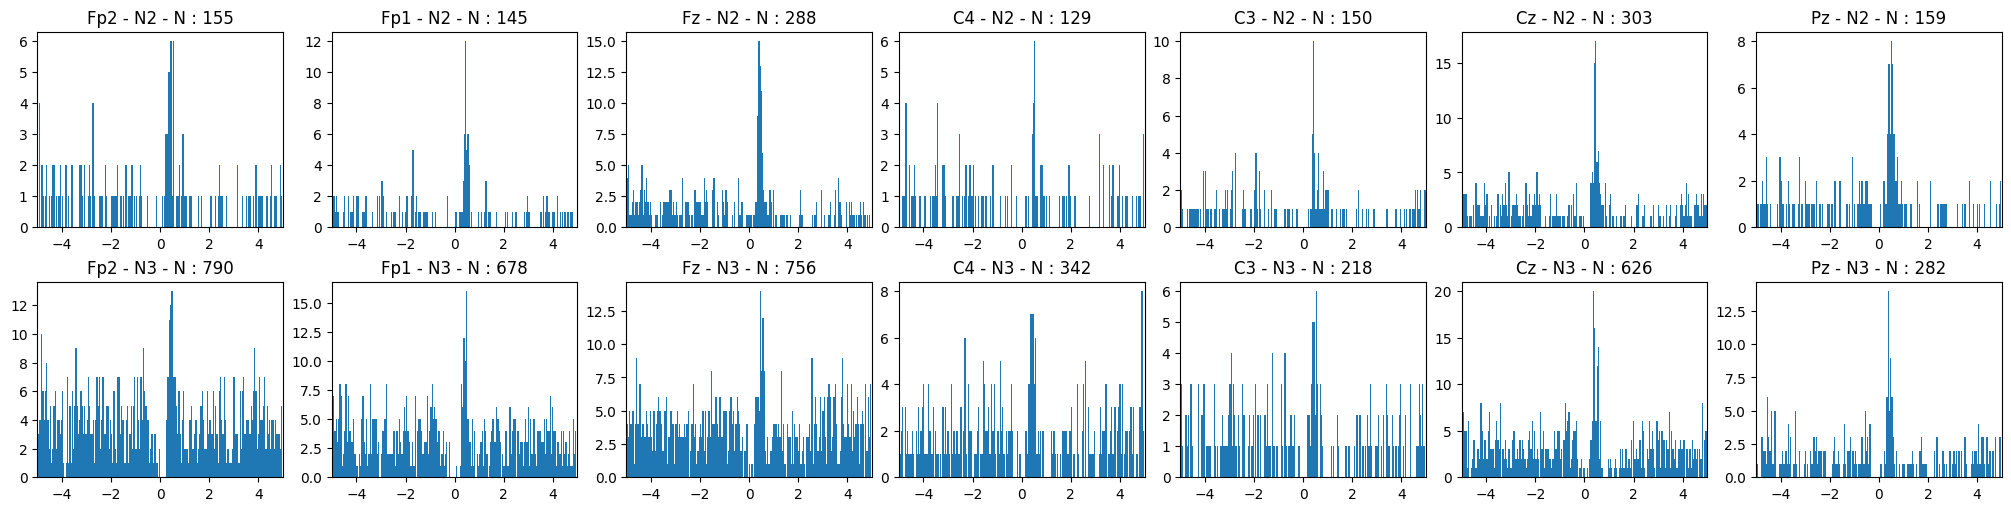

In [28]:
delta = 5
delta_t_by_bin = 0.05
nbins = int(delta * 2 / delta_t_by_bin)
print(nbins)

chans = [chan for chan in spindles['Channel'].unique() if not chan in ['T4','T3','O1','O2']]
stages = ['N2','N3']

nrows = len(stages)
ncols = len(chans)

fig, axs = plt.subplots(nrows, ncols, figsize = (20,5), constrained_layout = True)

for c, ch in enumerate(chans):
    for r, stage in enumerate(stages):
        
        sp = spindles[(spindles['Channel'] == ch) & (spindles['Stage_Letter'] == stage)]
        sw = slowwaves[(slowwaves['Channel'] == ch) & (slowwaves['Stage_Letter'] == stage)]
        cross = crosscorrelogram(sp['Peak'].values, sw['NegPeak'].values)
        cross_sel = cross[(cross < delta) & (cross > -delta)]
        N = cross_sel.size
        
        ax = axs[r,c]
        ax.set_title(f'{ch} - {stage} - N : {N}')
        ax.hist(cross_sel, bins = nbins, align = 'mid')
        ax.set_xlim(-delta,delta)
        
plt.show()

In [29]:
slowwaves[(slowwaves['NegPeak'] >  19974) & (slowwaves['NegPeak'] < 19976)]

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,SigmaPeak,PhaseAtSigmaPeak,ndPAC,Stage,Channel,IdxChannel,Stage_Letter
729,19974.585938,19975.570312,19975.785156,19976.015625,19976.269531,1.6836,-49.103372,56.923556,106.026928,493.507157,0.593965,19975.781250,-1.609380,0.490548,3,Fp2,0,N3
2543,19975.281250,19975.550781,19975.781250,19976.027344,19976.316406,1.0352,-99.375542,103.072436,202.447978,878.418346,0.965997,19975.851562,-1.163875,0.484193,3,Fz,2,N3
3519,19975.226562,19975.523438,19975.769531,19976.074219,19976.386719,1.1602,-62.967127,77.240035,140.207162,569.730690,0.861920,19976.019531,-0.349910,0.301465,3,C3,4,N3
5176,19975.226562,19975.523438,19975.816406,19976.085938,19976.500000,1.2734,-112.107847,56.550600,168.658447,575.687498,0.785299,19976.058594,-0.437020,0.372860,3,Pz,8,N3


In [30]:
(slowwaves['NegPeak'] - slowwaves['Start']).mean()

0.32741523526538585

In [31]:
(slowwaves['End'] - slowwaves['NegPeak']).mean()

0.8580737646532074

In [32]:
def cooccuring_sp_sw_df(spindles, slowwaves):
    features_cooccuring_sp = []
    sw_with_spindle_inside = []
    for ch in slowwaves['Channel'].unique():
        for stage in slowwaves['Stage_Letter'].unique():
            sw_staged_ch = slowwaves[(slowwaves['Channel'] == ch)&(slowwaves['Stage_Letter'] == stage)]
            sp_staged_ch = spindles[(spindles['Channel'] == ch)&(spindles['Stage_Letter'] == stage)]

            if not sw_staged_ch.shape[0] == 0:
                for i, row in sw_staged_ch.iterrows():

                    start_window = row['Start']
                    stop_window = row['End']
                    negpeak = row['NegPeak']
                    duration = row['Duration']

                    co_occuring_spindles = sp_staged_ch[(sp_staged_ch['Peak'] >= start_window) & (sp_staged_ch['Peak'] < stop_window)]
                    
                    if not co_occuring_spindles.shape[0] == 0:
                        sw_with_spindle_inside.append(i)
                        for s, sp in co_occuring_spindles.iterrows():

                            t = sp['Peak']
                            cooccuring_with_sw = True
                            absolute_t_vs_negpeak = t - negpeak
                            absolute_t_vs_start = t - start_window
                            relative_t_vs_duration = absolute_t_vs_start / duration
                            features_cooccuring_sp.append([s, cooccuring_with_sw, absolute_t_vs_negpeak, absolute_t_vs_start, relative_t_vs_duration])
                            
                            
                        
    cooccurors = pd.DataFrame(features_cooccuring_sp, columns = ['index','in_slowwave','t_vs_NegPeak_sw','t_vs_Start_sw','relative_t_in_sw']).set_index('index')
    
    sp_return = spindles.reindex(columns = list(spindles.columns) + list(cooccurors.columns))
    sp_return.loc[cooccurors.index,cooccurors.columns] = cooccurors
    sp_return.loc[:,'in_slowwave'] = sp_return['in_slowwave'].fillna(False)
    
    slowwaves_return = slowwaves.copy()
    slowwaves_return['sp_inside'] = np.nan
    slowwaves_return.loc[sw_with_spindle_inside, 'sp_inside'] = True
    slowwaves_return.loc[:,'sp_inside'] = slowwaves_return['sp_inside'].fillna(False)
    
    return sp_return, slowwaves_return

In [33]:
sp, sw = cooccuring_sp_sw_df(spindles, slowwaves)

/tmp/ipykernel_255936/2707966230.py:36: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sp_return.loc[:,'in_slowwave'] = sp_return['in_slowwave'].fillna(False)
/tmp/ipykernel_255936/2707966230.py:41: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  slowwaves_return.loc[:,'sp_inside'] = slowwaves_return['sp_inside'].fillna(False)


In [34]:
sp

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter,in_slowwave,t_vs_NegPeak_sw,t_vs_Start_sw,relative_t_in_sw
0,15.160156,15.910156,16.777344,1.617188,76.690796,14.541233,1.512471,0.058145,12.064345,16,0.462651,0,Fp2,0,W,False,NaN,NaN,NaN
1,22.515625,23.867188,24.289062,1.773438,77.093320,15.279712,1.575529,0.067565,11.343477,19,0.760440,0,Fp2,0,W,False,NaN,NaN,NaN
2,54.046875,54.343750,54.792969,0.746094,52.904826,11.853407,1.707664,0.080165,11.542135,9,0.395833,0,Fp2,0,W,False,NaN,NaN,NaN
3,65.800781,66.808594,67.613281,1.812500,150.039012,24.185366,1.568414,0.036664,12.304631,18,0.554839,0,Fp2,0,W,False,NaN,NaN,NaN
4,68.812500,69.324219,69.476562,0.664062,61.455435,14.984043,1.920190,0.090785,11.094523,7,0.766082,0,Fp2,0,W,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23909,31528.738281,31529.136719,31530.035156,1.296875,94.976470,20.093595,2.470019,0.163564,10.587642,14,0.306306,0,O2,10,W,False,NaN,NaN,NaN
23910,31577.636719,31579.066406,31579.316406,1.679688,107.811221,21.689694,2.355104,0.125338,10.808945,17,0.849188,0,O2,10,W,False,NaN,NaN,NaN
23911,31580.867188,31581.484375,31582.281250,1.414062,110.132798,21.056076,2.295392,0.127765,10.974576,13,0.435262,0,O2,10,W,False,NaN,NaN,NaN
23912,31606.960938,31607.433594,31607.636719,0.675781,49.719578,11.367692,2.265527,0.190931,10.706575,8,0.695402,0,O2,10,W,False,NaN,NaN,NaN


In [35]:
sw

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,SigmaPeak,PhaseAtSigmaPeak,ndPAC,Stage,Channel,IdxChannel,Stage_Letter,sp_inside
0,1.734375,2.039062,2.542969,2.843750,3.101562,1.3672,-52.298103,59.172636,111.470739,221.213250,0.731422,1.156250,2.324808,0.435491,0,Fp2,0,W,False
1,534.421875,534.648438,534.886719,535.101562,535.730469,1.3086,-99.702429,68.022204,167.724633,703.893544,0.764175,534.589844,2.706973,0.340889,0,Fp2,0,W,False
2,554.710938,555.011719,555.312500,555.757812,556.003906,1.2930,-85.189113,80.082351,165.271464,549.473958,0.773395,555.117188,-2.541248,0.462211,0,Fp2,0,W,False
3,1150.628906,1151.097656,1151.363281,1151.558594,1151.726562,1.0977,-59.513173,43.008693,102.521865,385.964669,0.910996,1151.156250,2.923094,0.125005,0,Fp2,0,W,False
4,1956.015625,1956.253906,1956.449219,1956.730469,1957.019531,1.0039,-51.359422,101.393842,152.753265,782.096715,0.996115,1956.191406,2.585990,0.196440,0,Fp2,0,W,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6137,27610.605469,27611.242188,27611.507812,27611.750000,27612.035156,1.4297,-71.162578,68.210883,139.373461,524.700087,0.699447,27610.750000,1.873669,0.189826,2,O2,10,N2,False
6138,27676.714844,27677.320312,27677.605469,27677.882812,27678.183594,1.4688,-59.905997,65.758214,125.664211,440.685452,0.680828,27678.054688,0.784315,0.165918,2,O2,10,N2,False
6139,27678.937500,27679.191406,27679.433594,27679.664062,27680.175781,1.2383,-56.320295,42.685468,99.005763,408.797988,0.807559,27678.531250,-1.738921,0.448633,2,O2,10,N2,False
6140,27819.488281,27819.773438,27820.027344,27820.238281,27820.527344,1.0391,-67.985230,46.733175,114.718405,451.814027,0.962371,27820.742188,-2.305341,0.178821,4,O2,10,R,False


In [36]:
pd.crosstab(sw['Stage_Letter'], sw['sp_inside'])

sp_inside,False,True
Stage_Letter,,
N1,26,1
N2,1254,361
N3,3716,529
R,122,5
W,118,10


In [37]:
sp['Frequency'] > spindles_freq_threshold[subject]

0        False
1        False
2        False
3        False
4        False
         ...  
23909    False
23910    False
23911    False
23912    False
23913    False
Name: Frequency, Length: 23914, dtype: bool

In [38]:
sp_speed = sp.copy()
sp_speed['Sp_Speed'] = np.nan
sp_speed.loc[:,'Sp_Speed'] = (sp['Frequency'] > spindles_freq_threshold[subject]).map({False:'SS',True:'FS'})

In [39]:
sp_speed

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter,in_slowwave,t_vs_NegPeak_sw,t_vs_Start_sw,relative_t_in_sw,Sp_Speed
0,15.160156,15.910156,16.777344,1.617188,76.690796,14.541233,1.512471,0.058145,12.064345,16,0.462651,0,Fp2,0,W,False,NaN,NaN,NaN,SS
1,22.515625,23.867188,24.289062,1.773438,77.093320,15.279712,1.575529,0.067565,11.343477,19,0.760440,0,Fp2,0,W,False,NaN,NaN,NaN,SS
2,54.046875,54.343750,54.792969,0.746094,52.904826,11.853407,1.707664,0.080165,11.542135,9,0.395833,0,Fp2,0,W,False,NaN,NaN,NaN,SS
3,65.800781,66.808594,67.613281,1.812500,150.039012,24.185366,1.568414,0.036664,12.304631,18,0.554839,0,Fp2,0,W,False,NaN,NaN,NaN,SS
4,68.812500,69.324219,69.476562,0.664062,61.455435,14.984043,1.920190,0.090785,11.094523,7,0.766082,0,Fp2,0,W,False,NaN,NaN,NaN,SS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23909,31528.738281,31529.136719,31530.035156,1.296875,94.976470,20.093595,2.470019,0.163564,10.587642,14,0.306306,0,O2,10,W,False,NaN,NaN,NaN,SS
23910,31577.636719,31579.066406,31579.316406,1.679688,107.811221,21.689694,2.355104,0.125338,10.808945,17,0.849188,0,O2,10,W,False,NaN,NaN,NaN,SS
23911,31580.867188,31581.484375,31582.281250,1.414062,110.132798,21.056076,2.295392,0.127765,10.974576,13,0.435262,0,O2,10,W,False,NaN,NaN,NaN,SS
23912,31606.960938,31607.433594,31607.636719,0.675781,49.719578,11.367692,2.265527,0.190931,10.706575,8,0.695402,0,O2,10,W,False,NaN,NaN,NaN,SS


In [40]:
sp_speed['Sp_Speed'].value_counts()

SS    17443
FS     6471
Name: Sp_Speed, dtype: int64

In [41]:
spindles = pd.read_excel(f'../event_detection/{subject}_spindles_cooccuring.xlsx', index_col = 0)

In [42]:
spindles

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter,in_slowwave,t_vs_NegPeak_sw,t_vs_Start_sw,relative_t_in_sw,Sp_Speed
0,15.160156,15.910156,16.777344,1.617188,76.690796,14.541233,1.512471,0.058145,12.064345,16,0.462651,0,Fp2,0,W,False,NaN,NaN,NaN,SS
1,22.515625,23.867188,24.289062,1.773438,77.093320,15.279712,1.575529,0.067565,11.343477,19,0.760440,0,Fp2,0,W,False,NaN,NaN,NaN,SS
2,54.046875,54.343750,54.792969,0.746094,52.904826,11.853407,1.707664,0.080165,11.542135,9,0.395833,0,Fp2,0,W,False,NaN,NaN,NaN,SS
3,65.800781,66.808594,67.613281,1.812500,150.039012,24.185366,1.568414,0.036664,12.304631,18,0.554839,0,Fp2,0,W,False,NaN,NaN,NaN,SS
4,68.812500,69.324219,69.476562,0.664062,61.455435,14.984043,1.920190,0.090785,11.094523,7,0.766082,0,Fp2,0,W,False,NaN,NaN,NaN,SS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23909,31528.738281,31529.136719,31530.035156,1.296875,94.976470,20.093595,2.470019,0.163564,10.587642,14,0.306306,0,O2,10,W,False,NaN,NaN,NaN,SS
23910,31577.636719,31579.066406,31579.316406,1.679688,107.811221,21.689694,2.355104,0.125338,10.808945,17,0.849188,0,O2,10,W,False,NaN,NaN,NaN,SS
23911,31580.867188,31581.484375,31582.281250,1.414062,110.132798,21.056076,2.295392,0.127765,10.974576,13,0.435262,0,O2,10,W,False,NaN,NaN,NaN,SS
23912,31606.960938,31607.433594,31607.636719,0.675781,49.719578,11.367692,2.265527,0.190931,10.706575,8,0.695402,0,O2,10,W,False,NaN,NaN,NaN,SS


In [43]:
pd.crosstab(spindles['in_slowwave'], spindles['Sp_Speed'])

Sp_Speed,FS,SS
in_slowwave,,
False,6056,16949
True,415,494


In [44]:
spindles.columns

Index(['Start', 'Peak', 'End', 'Duration', 'Amplitude', 'RMS', 'AbsPower',
       'RelPower', 'Frequency', 'Oscillations', 'Symmetry', 'Stage', 'Channel',
       'IdxChannel', 'Stage_Letter', 'in_slowwave', 't_vs_NegPeak_sw',
       't_vs_Start_sw', 'relative_t_in_sw', 'Sp_Speed'],
      dtype='object')

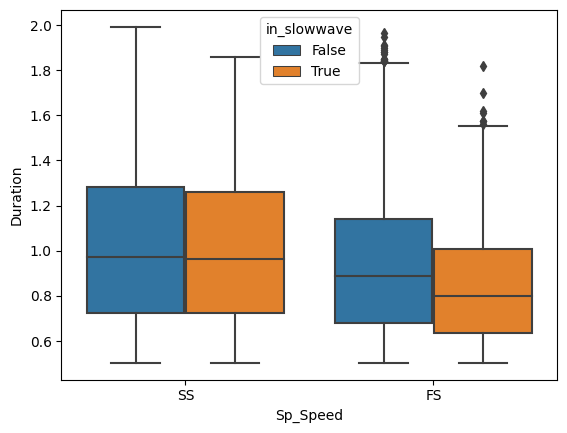

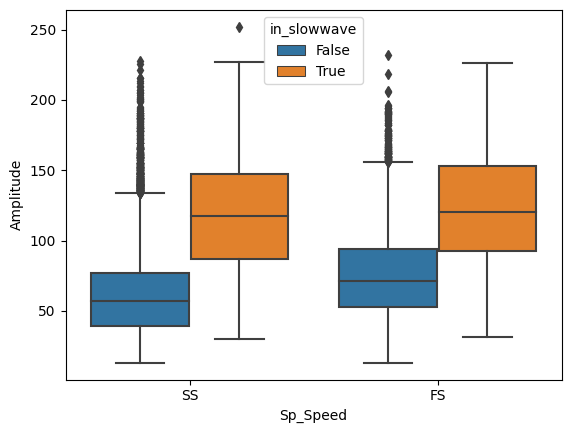

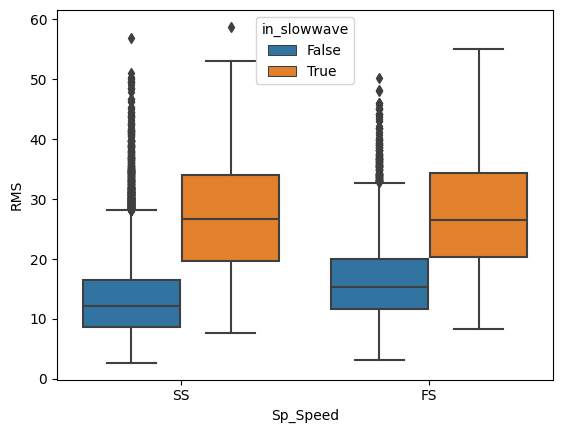

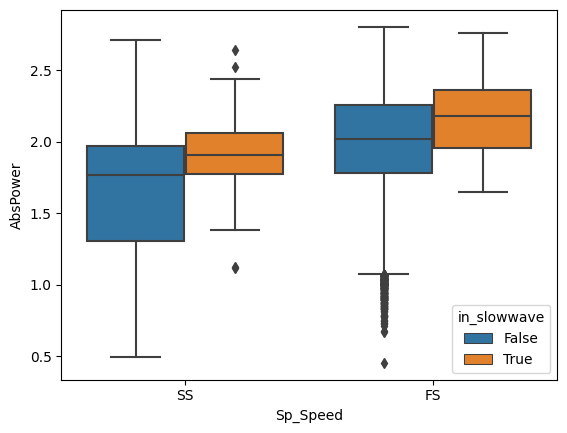

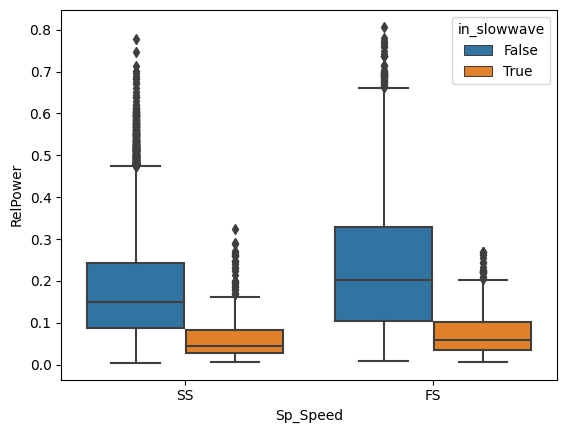

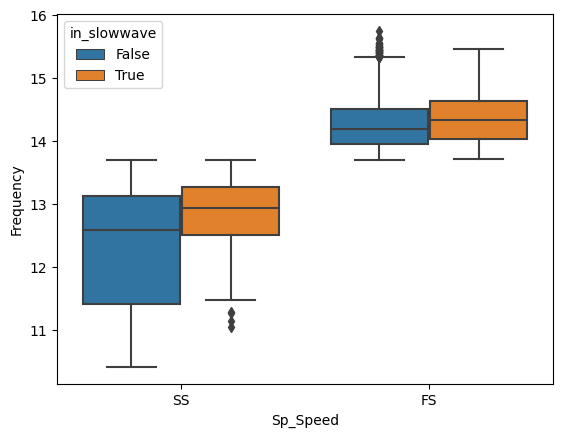

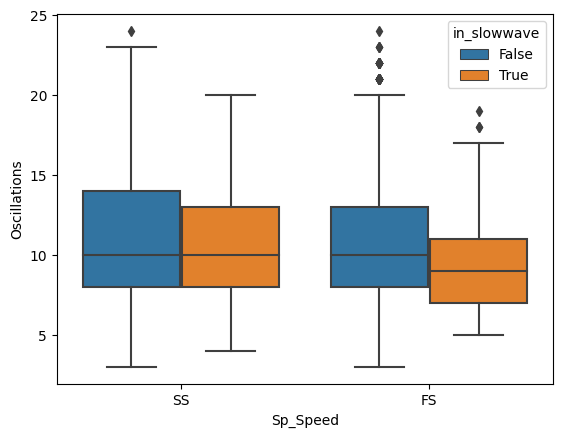

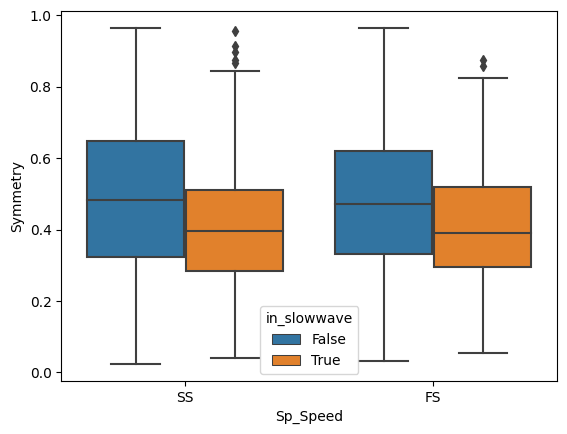

In [45]:
for metric in ['Duration', 'Amplitude', 'RMS', 'AbsPower',
       'RelPower', 'Frequency', 'Oscillations', 'Symmetry']:
    sns.boxplot(data = spindles, x = 'Sp_Speed', y = metric, hue = 'in_slowwave')
    plt.show()

In [46]:
spindles

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter,in_slowwave,t_vs_NegPeak_sw,t_vs_Start_sw,relative_t_in_sw,Sp_Speed
0,15.160156,15.910156,16.777344,1.617188,76.690796,14.541233,1.512471,0.058145,12.064345,16,0.462651,0,Fp2,0,W,False,NaN,NaN,NaN,SS
1,22.515625,23.867188,24.289062,1.773438,77.093320,15.279712,1.575529,0.067565,11.343477,19,0.760440,0,Fp2,0,W,False,NaN,NaN,NaN,SS
2,54.046875,54.343750,54.792969,0.746094,52.904826,11.853407,1.707664,0.080165,11.542135,9,0.395833,0,Fp2,0,W,False,NaN,NaN,NaN,SS
3,65.800781,66.808594,67.613281,1.812500,150.039012,24.185366,1.568414,0.036664,12.304631,18,0.554839,0,Fp2,0,W,False,NaN,NaN,NaN,SS
4,68.812500,69.324219,69.476562,0.664062,61.455435,14.984043,1.920190,0.090785,11.094523,7,0.766082,0,Fp2,0,W,False,NaN,NaN,NaN,SS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23909,31528.738281,31529.136719,31530.035156,1.296875,94.976470,20.093595,2.470019,0.163564,10.587642,14,0.306306,0,O2,10,W,False,NaN,NaN,NaN,SS
23910,31577.636719,31579.066406,31579.316406,1.679688,107.811221,21.689694,2.355104,0.125338,10.808945,17,0.849188,0,O2,10,W,False,NaN,NaN,NaN,SS
23911,31580.867188,31581.484375,31582.281250,1.414062,110.132798,21.056076,2.295392,0.127765,10.974576,13,0.435262,0,O2,10,W,False,NaN,NaN,NaN,SS
23912,31606.960938,31607.433594,31607.636719,0.675781,49.719578,11.367692,2.265527,0.190931,10.706575,8,0.695402,0,O2,10,W,False,NaN,NaN,NaN,SS


In [47]:
sp_staged = spindles[spindles['Stage_Letter'].isin(['N2','N3'])]

In [48]:
pd.crosstab(index = [ sp_staged['Sp_Speed'], sp_staged['Channel']] , columns = [ sp_staged['in_slowwave'], sp_staged['Stage_Letter']], normalize = False)

in_slowwave      False      True     
Stage_Letter        N2   N3    N2  N3
Sp_Speed Channel                     
FS       C3        684  185    27  23
         C4        648  196    15  28
         Cz        836  258    51  88
         Fp1       109   12     8   5
         Fp2       111   22     5   9
         Fz        353   87    30   9
         O1        163   16     5   2
         O2        169   15     5   1
         Pz        826  171    47  50
         T3        205   70     0   0
         T4        184   47     0   0
SS       C3        525  135    11  15
         C4        606  163     7  24
         Cz        247   75    25   9
         Fp1      1091  366    35  80
         Fp2      1079  357    35  97
         Fz        810  283    48  86
         O1        115   10     2   1
         O2        128    6     4   1
         Pz        100    5     3   1
         T3       1134  362     0   0
         T4       1056  336     1   0

In [71]:
%matplotlib inline

<AxesSubplot: xlabel='Sp_Speed,Channel'>

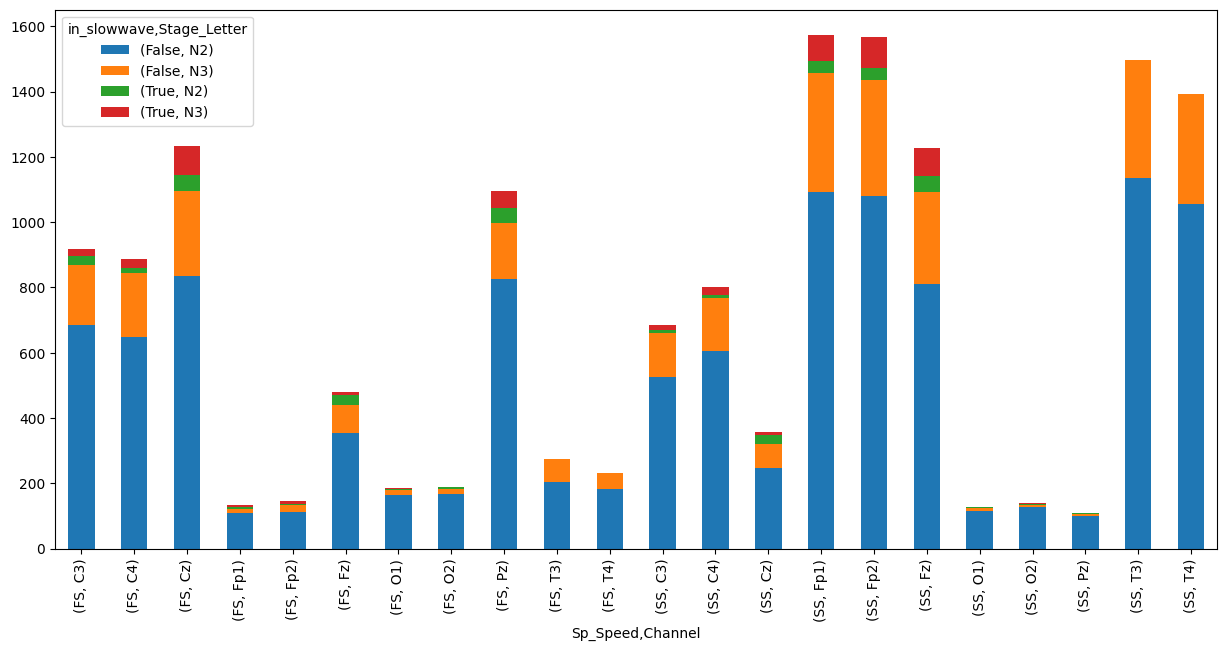

In [74]:
fig, ax = plt.subplots(figsize = (15,7))
pd.crosstab(index = [ sp_staged['Sp_Speed'], sp_staged['Channel']] , columns = [ sp_staged['in_slowwave'], sp_staged['Stage_Letter']], normalize = False).plot.bar(stacked = True, ax=ax)

In [49]:
%matplotlib widget

In [50]:
def filter_sig(sig, srate, lowcut=None, highcut=None, order = 4, ftype = 'butter', verbose = False, show = False):
        
    if lowcut is None and not highcut is None:
        btype = 'lowpass'
        cut = highcut
        
    if not lowcut is None and highcut is None:
        btype = 'highpass'
        cut = lowcut
        
    if not lowcut is None and not highcut is None:
        btype = 'bandpass'
        
    if btype in ('bandpass', 'bandstop'):
        band = [lowcut, highcut]
        assert len(band) == 2
        Wn = [e / srate * 2 for e in band]
    else:
        Wn = float(cut) / srate * 2
        
    filter_mode = 'sos' 
    sos = signal.iirfilter(order, Wn, analog=False, btype=btype, ftype=ftype, output=filter_mode)
    filtered_sig = signal.sosfiltfilt(sos, sig, axis=0)
    if verbose:
        print(f'{ftype} iirfilter of {order}th-order')
        print(f'btype : {btype}')
        
            
    if show:
        w, h = signal.sosfreqz(sos,fs=srate)
        fig, ax = plt.subplots()
        ax.plot(w, np.abs(h))
        ax.set_title('Frequency response')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Amplitude')
        plt.show()
        
    return filtered_sig

In [51]:
subject = 'S10'

In [52]:
data = xr.open_dataarray(f'../preproc/{subject}_reref.nc') # load preprocessed data (lazy load)

In [53]:
# rsp = data.sel(chan = 'DEBIT', time = slice(10,3000)).values
rsp = data.sel(chan = 'DEBIT').values

In [54]:
def detect_zerox(sig):
    rises, = np.where((sig[:-1] <=0) & (sig[1:] >0)) # detect where sign inversion from - to +
    decays, = np.where((sig[:-1] >=0) & (sig[1:] <0)) # detect where sign inversion from + to -
    if rises[0] > decays[0]: # first point detected has to be a rise
        decays = decays[1:] # so remove the first decay if is before first rise
    if rises[-1] > decays[-1]: # last point detected has to be a decay
        rises = rises[:-1] # so remove the last rise if is after last decay
    return pd.DataFrame.from_dict({'rises':rises, 'decays':decays}, orient = 'index').T

def get_cycle_features(zerox, sig, srate):
    features = []
    for i , row in zerox.iterrows(): # last cycle is probably not complete so it is removed in any case
        if i != zerox.index[-1]:
            start = int(row['rises'])
            transition = int(row['decays'])
            stop = int(zerox.loc[i+1, 'rises'])
            start_t = start / srate
            transition_t = transition / srate
            stop_t = stop / srate
            cycle_duration = stop_t - start_t
            inspi_duration = transition_t - start_t
            expi_duration = stop_t - transition_t
            cycle_freq = 1 / cycle_duration
            cycle_ratio = inspi_duration / cycle_duration
            inspi_amplitude = np.max(np.abs(sig[start:transition]))
            expi_amplitude = np.max(np.abs(sig[transition:stop]))
            cycle_amplitude = inspi_amplitude + expi_amplitude
            inspi_volume = np.trapz(np.abs(sig[start:transition]))
            expi_volume = np.trapz(np.abs(sig[transition:stop]))
            cycle_volume = inspi_volume + expi_volume
            second_volume = cycle_freq * cycle_volume
            features.append([start, transition , stop, start_t, transition_t, stop_t, cycle_duration,
                             inspi_duration, expi_duration, cycle_freq, cycle_ratio, inspi_amplitude,
                             expi_amplitude,cycle_amplitude, inspi_volume, expi_volume, cycle_volume, second_volume])
    df_features = pd.DataFrame(features, columns = ['start','transition','stop','start_time','transition_time',
                                                    'stop_time','cycle_duration','inspi_duration','expi_duration','cycle_freq','cycle_ratio',
                                                    'inspi_amplitude','expi_amplitude','cycle_amplitude','inspi_volume','expi_volume','cycle_volume','second_volume'])
    return df_features

def zscore(sig):
    return (sig - np.median(sig)) / np.std(sig)

def get_resp_features(rsp, srate):
    zerox = detect_zerox(rsp)
    features = get_cycle_features(zerox, rsp, srate)
    return features

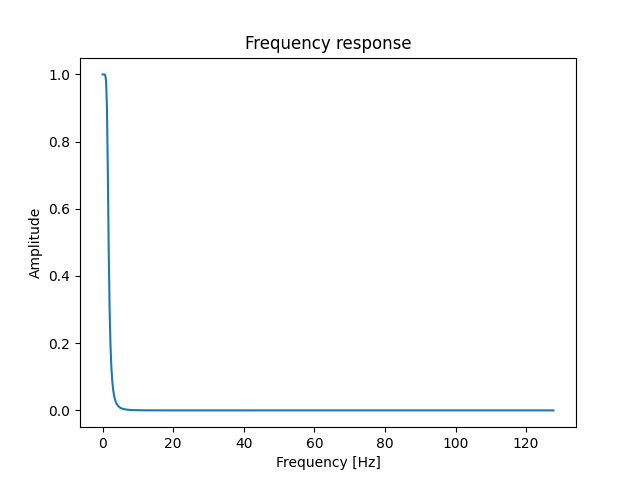

In [55]:
resp_filtered = filter_sig(rsp, srate, None, 1.5, order = 4, show = True) # filtering signal
resp_filtered_zscored = zscore(resp_filtered)
resp_features = get_resp_features(resp_filtered_zscored - 0.02, srate) # compute resp features 

In [56]:
cols = ['cycle_duration', 'inspi_duration', 'expi_duration',
       'cycle_freq', 'cycle_ratio', 'inspi_amplitude', 'expi_amplitude','cycle_amplitude',
       'inspi_volume', 'expi_volume','cycle_volume','second_volume']

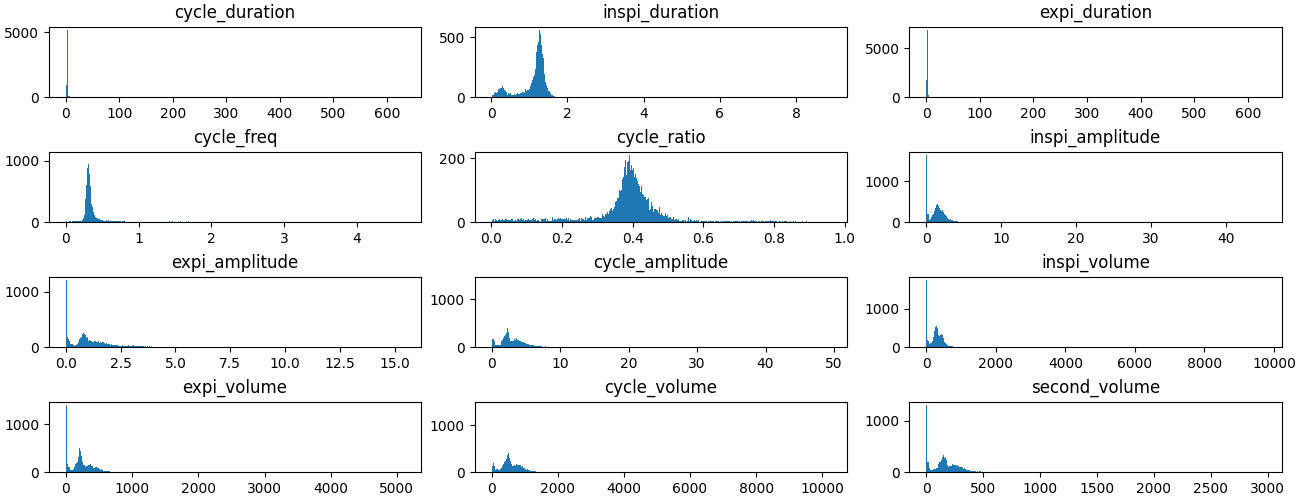

In [57]:
nrows = 4
ncols = 3
col_grid = np.array(cols).reshape(4,3)
bins = int(resp_features.shape[0] / 20)
fig, axs = plt.subplots(nrows, ncols, figsize = (13,5), constrained_layout = True)
for r in range(nrows):
    for c in range(ncols):
        colname = col_grid[r,c]
        ax = axs[r,c]
        ax.hist(resp_features[colname].values, bins=bins)
        ax.set_title(colname)

In [58]:
def cleaning_resp_features(resp_features, verbose= True):
    keep_second_volume = resp_features['second_volume'] > 20
    keep_cycle_ratio = resp_features['cycle_ratio'] < 0.6
    keep_duration = (resp_features['cycle_duration'] > 1) & (resp_features['cycle_duration'] < 15)
    keep = keep_second_volume & keep_cycle_ratio
    removed = ~ keep
    clean_resp_features = resp_features[keep]
    if verbose:
        n_removed = resp_features.shape[0] - clean_resp_features.shape[0]
        print(f'{n_removed} cycles removed')
    return clean_resp_features

1872 cycles removed


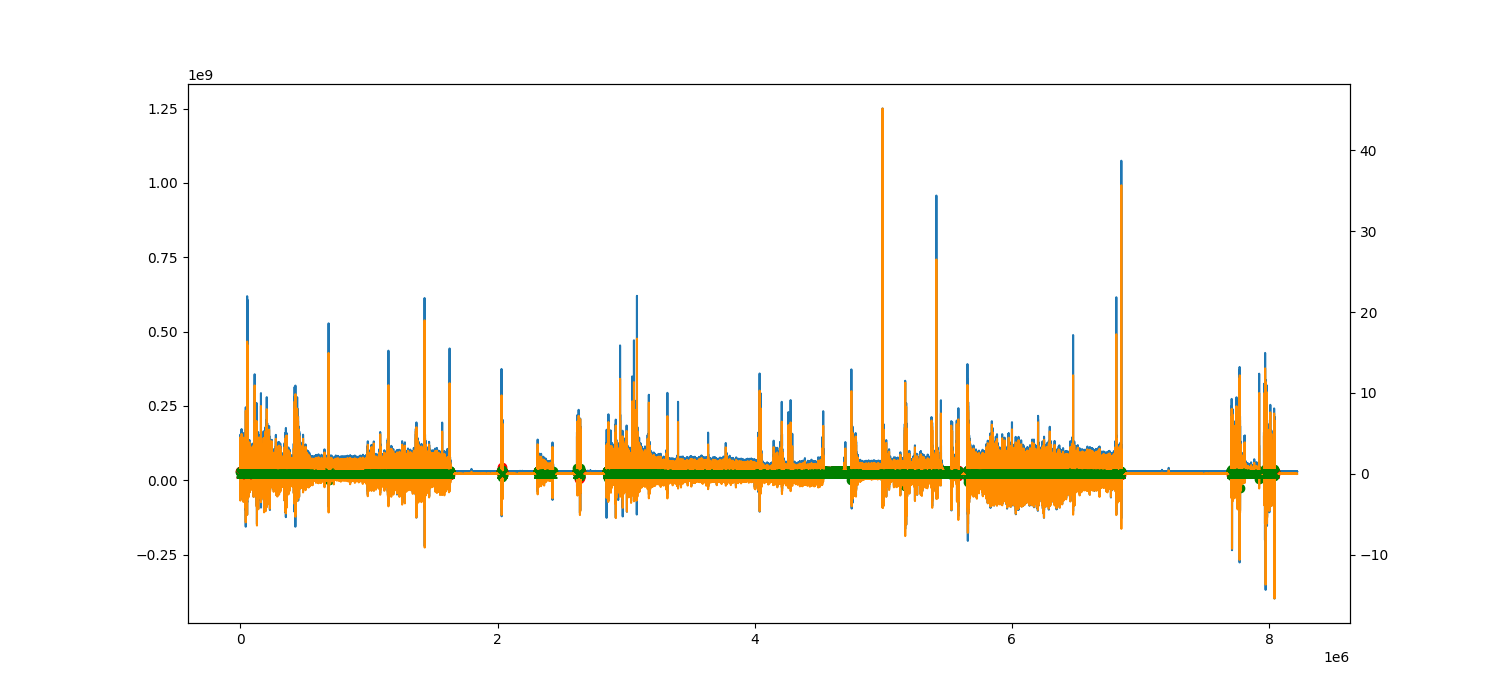

In [59]:
fig, ax = plt.subplots(figsize = (15,7))

clean_resp_features = cleaning_resp_features(resp_features)

starts = clean_resp_features['start']
transitions = clean_resp_features['transition']

ax.plot(rsp)
ax.plot(starts, rsp[starts], 'o', color = 'r')
ax.plot(transitions, rsp[transitions], 'o', color = 'g')

ax2 = ax.twinx()
ax2.plot(resp_filtered_zscored, color = 'darkorange')
ax2.plot(starts, resp_filtered_zscored[starts], 'x', color = 'r')
ax2.plot(transitions, resp_filtered_zscored[transitions], 'x', color = 'g')

In [60]:
concat_rsp_features = []
for subject in subjects: # loop on subjects
    df_subject = pd.read_excel(f'../resp_features/{subject}_resp_features_tagged.xlsx', index_col = 0) # load rsp features tagged by staging and presence of events in resp cycles
    df_subject.insert(0, 'subject', subject) # insert subject id a first column
    concat_rsp_features.append(df_subject) # append rsp features of the subject to a list
pooled_features = pd.concat(concat_rsp_features)

In [61]:
pooled_features

,subject,start,transition,stop,start_time,transition_time,stop_time,cycle_duration,inspi_duration,expi_duration,...,inspi_amplitude,expi_amplitude,cycle_amplitude,inspi_volume,expi_volume,cycle_volume,second_volume,sleep_stage,Spindle_Tag,SlowWave_Tag
0,S1,896,1046,2087,3.500000,4.085938,8.152344,4.652344,0.585938,4.066406,...,0.150379,1.688273,1.838652,13.789112,349.357860,363.146972,78.056780,W,0,0
1,S1,2087,2382,3126,8.152344,9.304688,12.210938,4.058594,1.152344,2.906250,...,4.800952,3.196878,7.997830,838.622527,619.515866,1458.138393,359.271827,W,0,0
2,S1,3126,3312,3918,12.210938,12.937500,15.304688,3.093750,0.726562,2.367188,...,1.449591,0.794400,2.243991,158.173327,167.594168,325.767495,105.298584,W,0,0
3,S1,3918,4118,4664,15.304688,16.085938,18.218750,2.914062,0.781250,2.132812,...,1.162156,0.882823,2.044979,132.971271,169.484028,302.455299,103.791631,W,0,0
4,S1,4664,4914,5410,18.218750,19.195312,21.132812,2.914062,0.976562,1.937500,...,0.946188,0.843332,1.789521,139.854629,177.167108,317.021737,108.790301,W,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7829,S20,8185654,8186003,8186377,31975.210938,31976.574219,31978.035156,2.824219,1.363281,1.460938,...,2.019241,1.659076,3.678316,391.535785,242.232964,633.768749,224.404979,N2,0,0
7830,S20,8186526,8186835,8187340,31978.617188,31979.824219,31981.796875,3.179688,1.207031,1.972656,...,2.108202,1.159723,3.267925,374.092246,202.264741,576.356987,181.262148,N2,0,0
7831,S20,8187340,8187709,8188095,31981.796875,31983.238281,31984.746094,2.949219,1.441406,1.507812,...,2.002044,1.548776,3.550820,420.036465,256.717454,676.753918,229.468878,N2,1,0
7832,S20,8188322,8188678,8189068,31985.632812,31987.023438,31988.546875,2.914062,1.390625,1.523438,...,1.787899,1.426388,3.214287,376.528474,222.095328,598.623802,205.425862,N2,1,0


In [62]:
sns.boxplot(data = pooled_features, x = 'sleep_stage', y = 'second_volume')

<AxesSubplot: xlabel='sleep_stage', ylabel='second_volume'>

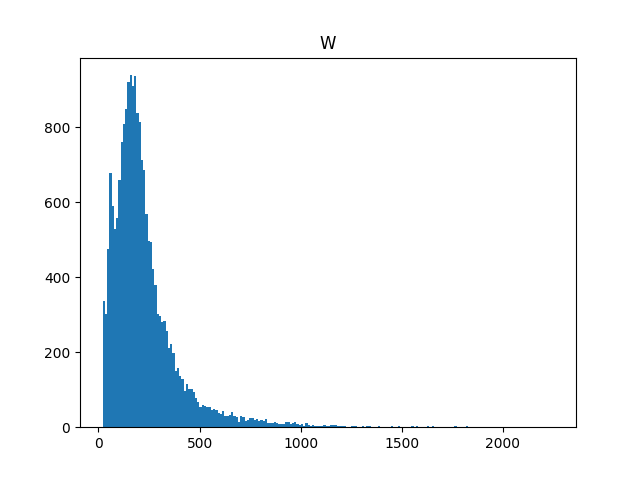

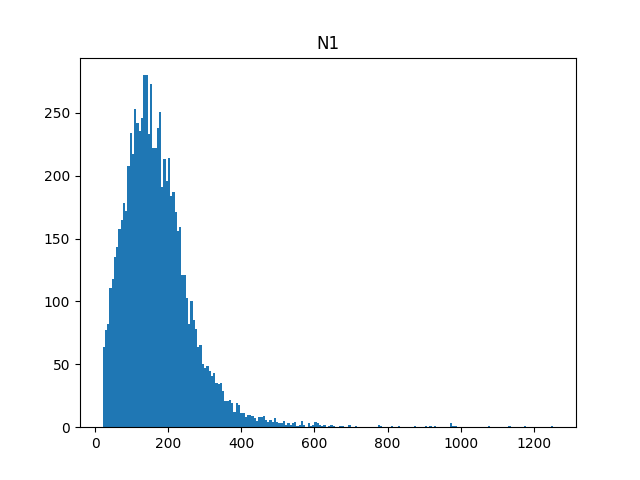

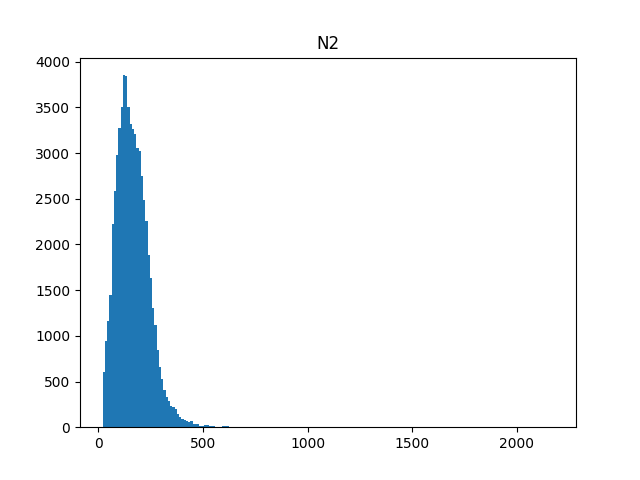

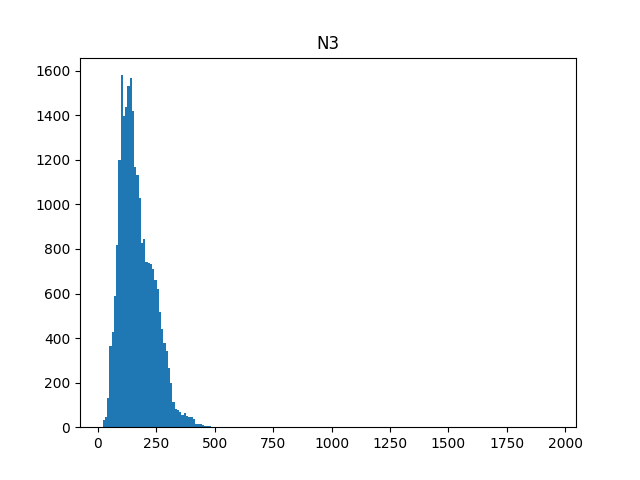

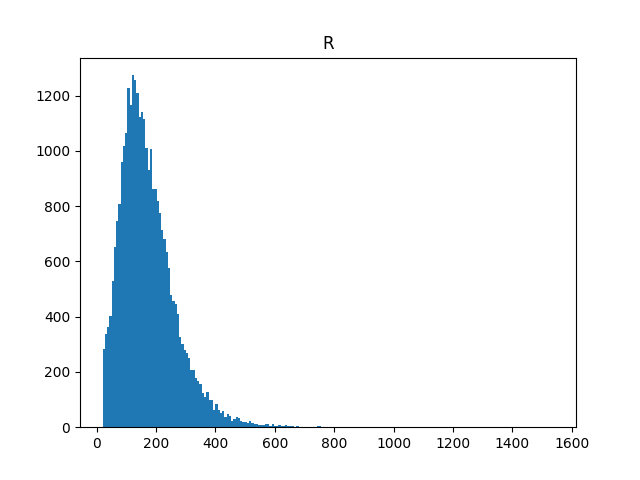

In [63]:
for stage in pooled_features['sleep_stage'].unique():
    pooled_features_stage = pooled_features[pooled_features['sleep_stage'] == stage]
    fig, ax = plt.subplots()
    ax.hist(pooled_features_stage['second_volume'] , bins = 200)
    ax.set_title(stage)
    plt.show()

In [64]:
from scipy import stats

In [65]:
density = stats.gaussian_kde(pooled_features['second_volume'].values)

In [66]:
xs = np.linspace(0,800,500)
density.covariance_factor = lambda : .01
density._compute_covariance()

In [67]:
def get_kde(x, maximum = None, bw_adjust = 0.01, n_points=200):
    if maximum is None:
        xs = np.linspace(0,max(x),n_points)
    else:
        xs = np.linspace(0,maximum,n_points)
    density = stats.gaussian_kde(x)
    density.covariance_factor = lambda : bw_adjust
    density._compute_covariance()
    return xs, density(xs)

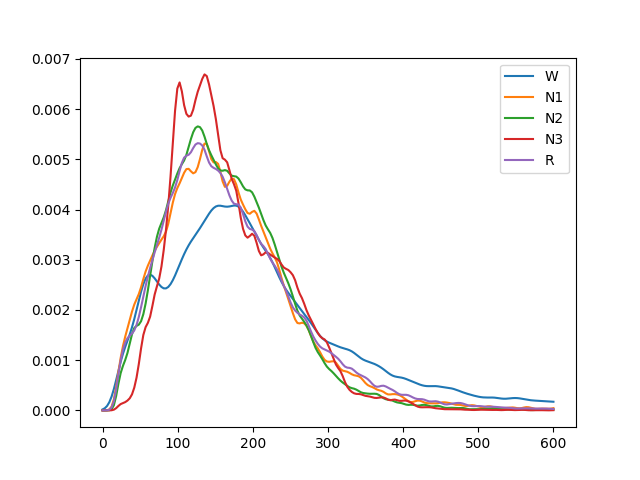

In [68]:
fig, ax = plt.subplots()

for stage in pooled_features['sleep_stage'].unique():
    pooled_features_stage = pooled_features[pooled_features['sleep_stage'] == stage]
    x, y = get_kde(pooled_features_stage['second_volume'], bw_adjust = 0.05, maximum = 600)
    ax.plot(x,y, label = stage)
ax.legend()
plt.show()

In [64]:
concat = []
for subject in subjects:
    concat.append(pd.read_excel(f'../event_detection/{subject}_spindles_cooccuring.xlsx', index_col = 0))

In [65]:
spindles = pd.concat(concat)

In [66]:
spindles.head()

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter,in_slowwave,t_vs_NegPeak_sw,t_vs_Start_sw,relative_t_in_sw,Sp_Speed
0,15.160156,15.910156,16.777344,1.617188,76.690796,14.541233,1.512471,0.058145,12.064345,16,0.462651,0,Fp2,0,W,False,NaN,NaN,NaN,SS
1,22.515625,23.867188,24.289062,1.773438,77.093320,15.279712,1.575529,0.067565,11.343477,19,0.760440,0,Fp2,0,W,False,NaN,NaN,NaN,SS
2,54.046875,54.343750,54.792969,0.746094,52.904826,11.853407,1.707664,0.080165,11.542135,9,0.395833,0,Fp2,0,W,False,NaN,NaN,NaN,SS
3,65.800781,66.808594,67.613281,1.812500,150.039012,24.185366,1.568414,0.036664,12.304631,18,0.554839,0,Fp2,0,W,False,NaN,NaN,NaN,SS
4,68.812500,69.324219,69.476562,0.664062,61.455435,14.984043,1.920190,0.090785,11.094523,7,0.766082,0,Fp2,0,W,False,NaN,NaN,NaN,SS


In [67]:
spindles = spindles[spindles['Stage_Letter'].isin(['N2','N3'])]

In [69]:
spindles = spindles[spindles['Channel'] == 'Fz']

In [70]:
index = [ spindles['Sp_Speed'], ]
columns = [ spindles['in_slowwave'], spindles['Stage_Letter']]

In [74]:
pd.crosstab(index = index , columns = columns)

in_slowwave   False       True       
Stage_Letter     N2    N3    N2    N3
Sp_Speed                             
FS            11262  2143   407   593
SS            19339  7088   728  1941

<AxesSubplot: xlabel='Sp_Speed'>

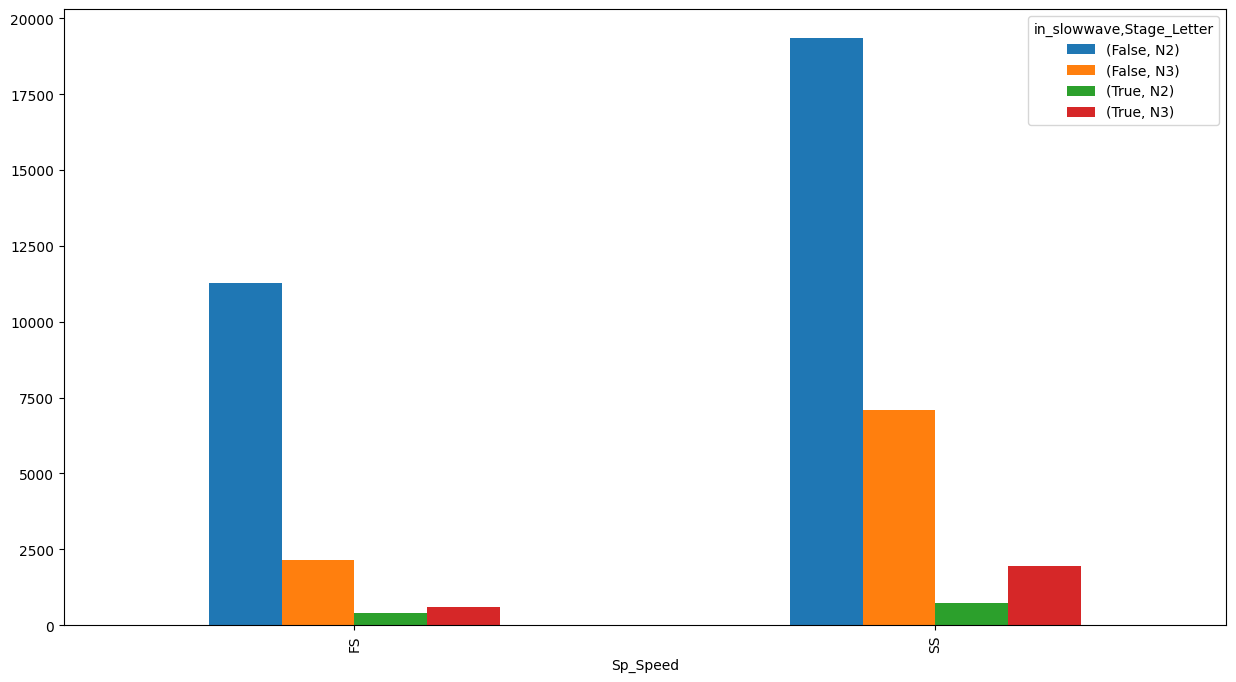

In [72]:
fig, ax = plt.subplots(figsize = (15,8))
pd.crosstab(index = index , columns = columns).plot.bar(stacked = False, ax=ax)

In [ ]:
index = [ spindles['ChanGroup'], spindles['Sp_Speed'], ]
columns = [ spindles['in_slowwave'], spindles['Stage_Letter']]
fig, ax = plt.subplots(figsize = (15,8))
pd.crosstab(index = index , columns = columns).plot.bar(stacked = False, ax=ax)

<AxesSubplot: xlabel='ChanGroup,Sp_Speed'>

<AxesSubplot: xlabel='ChanGroup,Sp_Speed'>

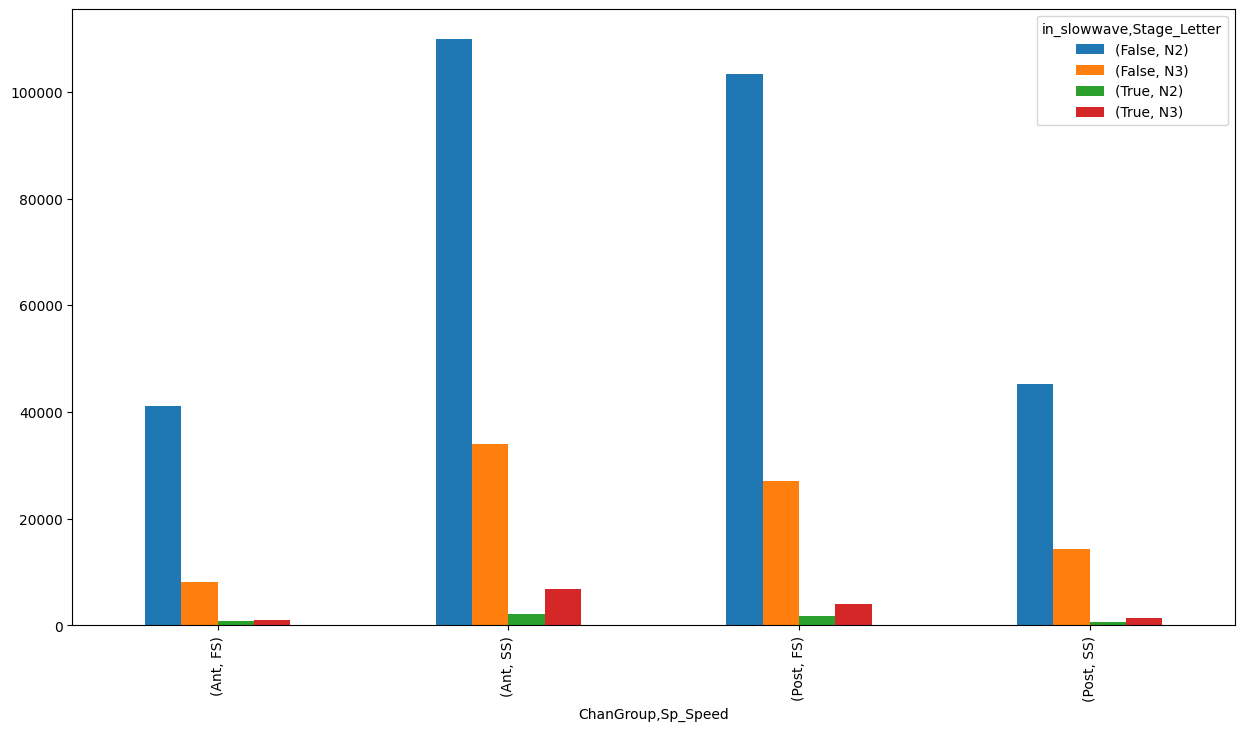

In [115]:
fig, ax = plt.subplots(figsize = (15,8))
pd.crosstab(index = index , columns = columns).plot.bar(stacked = False, ax=ax)

In [93]:
spindles['Channel'].unique()

array(['Fp2', 'Fp1', 'Fz', 'C4', 'C3', 'Cz', 'T4', 'T3', 'Pz', 'O1', 'O2'],
      dtype=object)

In [122]:
mapper = {'Fp2':'FT','Fp1':'FT','Fz':'Ant','C4':'OC','C3':'OC','C':'OC','T4':'FT','T3':'FT','Pz':'OC','O1':'OC','O2':'OC'}

In [123]:
spindles['ChanGroup'] = spindles['Channel'].map(mapper)

In [108]:
ecg  = -data.sel(chan = 'ECG').values

In [109]:
ecg_filt = gh.iirfilt(ecg, srate, 5, 45, order = 10)

In [112]:
peaks = gh.ecg_peaks(ecg_filt, srate)

In [113]:
rris = gh.peaks_to_RRI(peaks, srate)

In [121]:
rris.shape

(30451,)

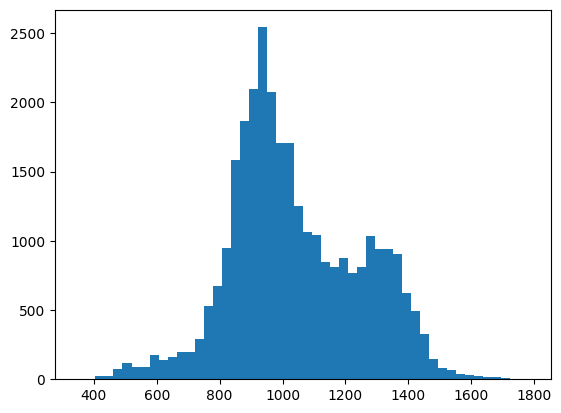

In [134]:
fig, ax = plt.subplots()
ax.hist(rris, bins = 50)
plt.show()

In [137]:
gh.RMSSD(rris[rris < 1000])

94.48187110506512

In [13]:
def load_dict(path):
    with open(path, 'r') as fp:
        data = json.load(fp)
    return data

In [14]:
cycles_ratios = pd.read_excel('../resp_stats/cycle_ratios.xlsx', index_col = 0).set_index(['subject','sleep_stage'])

In [15]:
cycles_ratios

cycle_ratio
subject sleep_stage             
S1      N1              0.423863
        N2              0.447983
        N3              0.429079
        R               0.486617
        W               0.433350
...                          ...
mean    N1              0.409521
        N2              0.421494
        N3              0.423598
        R               0.451892
        W               0.393065

[105 rows x 1 columns]

In [25]:
cycles_ratios.mean()[0]

0.4184672391111721

In [18]:
pooled_angles = load_dict('../events_coupling/pooled_angles.txt')

In [19]:
def circular_plot_angles(angles, color, ax=None, ratio_plot = 0.42, bins = 18):
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection = 'polar'), constrained_layout = True)
        
    N_events = angles.size # number of angles computed and distributed = number of events detected and computed (all subjects pooled)
    ax.hist(angles, bins = bins, density = False, edgecolor = 'black', color = color ) # polar histogram of distribution of angles of all subjects (in radians)
    ax.set_rticks([]) # remove vector lengths
    # ax.set_title(f'{ev_title} - Stage = {stage} - N = {N_events}', fontsize = 15, y = 1.1) 

    tick = [ax.get_rmax()*0.995, ax.get_rmax() * 0.99] # will display some markers at the exterior part of the polarplot (indicating respi phase)
    tick_pos = ratio_plot * 360 # angle where ticks will be colored differently = at the inspi to expi transition
    for t in np.deg2rad(np.arange(0, 360, 2)): # loop ticks displaying around the polar circle
        if t <= np.deg2rad(tick_pos) and t >= 0: # if angle < resp transition, color is red
            color = 'r'
        elif t >= np.deg2rad(tick_pos) and t <= np.deg2rad(360): # if angle > resp transition, color is black
            color = 'k'
        ax.plot([t, t], tick, lw=8, color=color) # plot the ticks, lw = linewidth = width of each tick
    ax.set_xticks(np.deg2rad([0, 90 , tick_pos , 180 , 270])) # at this angles in degrees, ticks labels will be present
    ax.set_xticklabels(['Start', '90°', 'I>E', '180°','270°']) # labelize polar plot angles
    return ax

In [20]:
bars_colors = {'sp':{'N2':None,'N3':'skyblue'},'sw':{'N2':'forestgreen','N3':'limegreen'}} # colors for polarplots

In [21]:
event_types_titles = {'sp':'Spindles','sw':'Slow-Waves'}

In [22]:
dict_figure = {'sp':{'N2':{'SS':{'inslowwave':{'pos':(0,0), 'color':None},'outslowwave':{'pos':(0,1), 'color':None}},'FS':{'inslowwave':{'pos':(0,2), 'color':None},'outslowwave':{'pos':(0,3), 'color':None}}},
                       'N3':{'SS':{'inslowwave':{'pos':(1,0), 'color':'skyblue'},'outslowwave':{'pos':(1,1), 'color':'skyblue'}},'FS':{'inslowwave':{'pos':(1,2), 'color':'skyblue'},'outslowwave':{'pos':(1,3), 'color':'skyblue'}}},
                      },
                 'sw':{'N2':{'withSp':{'pos':(2,0), 'color':'forestgreen'},'NoSp':{'pos':(2,1), 'color':'forestgreen'}},'N3':{'withSp':{'pos':(2,2), 'color':'limegreen'},'NoSp':{'pos':(2,3), 'color':'limegreen'}}}
                }

In [23]:
nrows = 3
ncols = 4

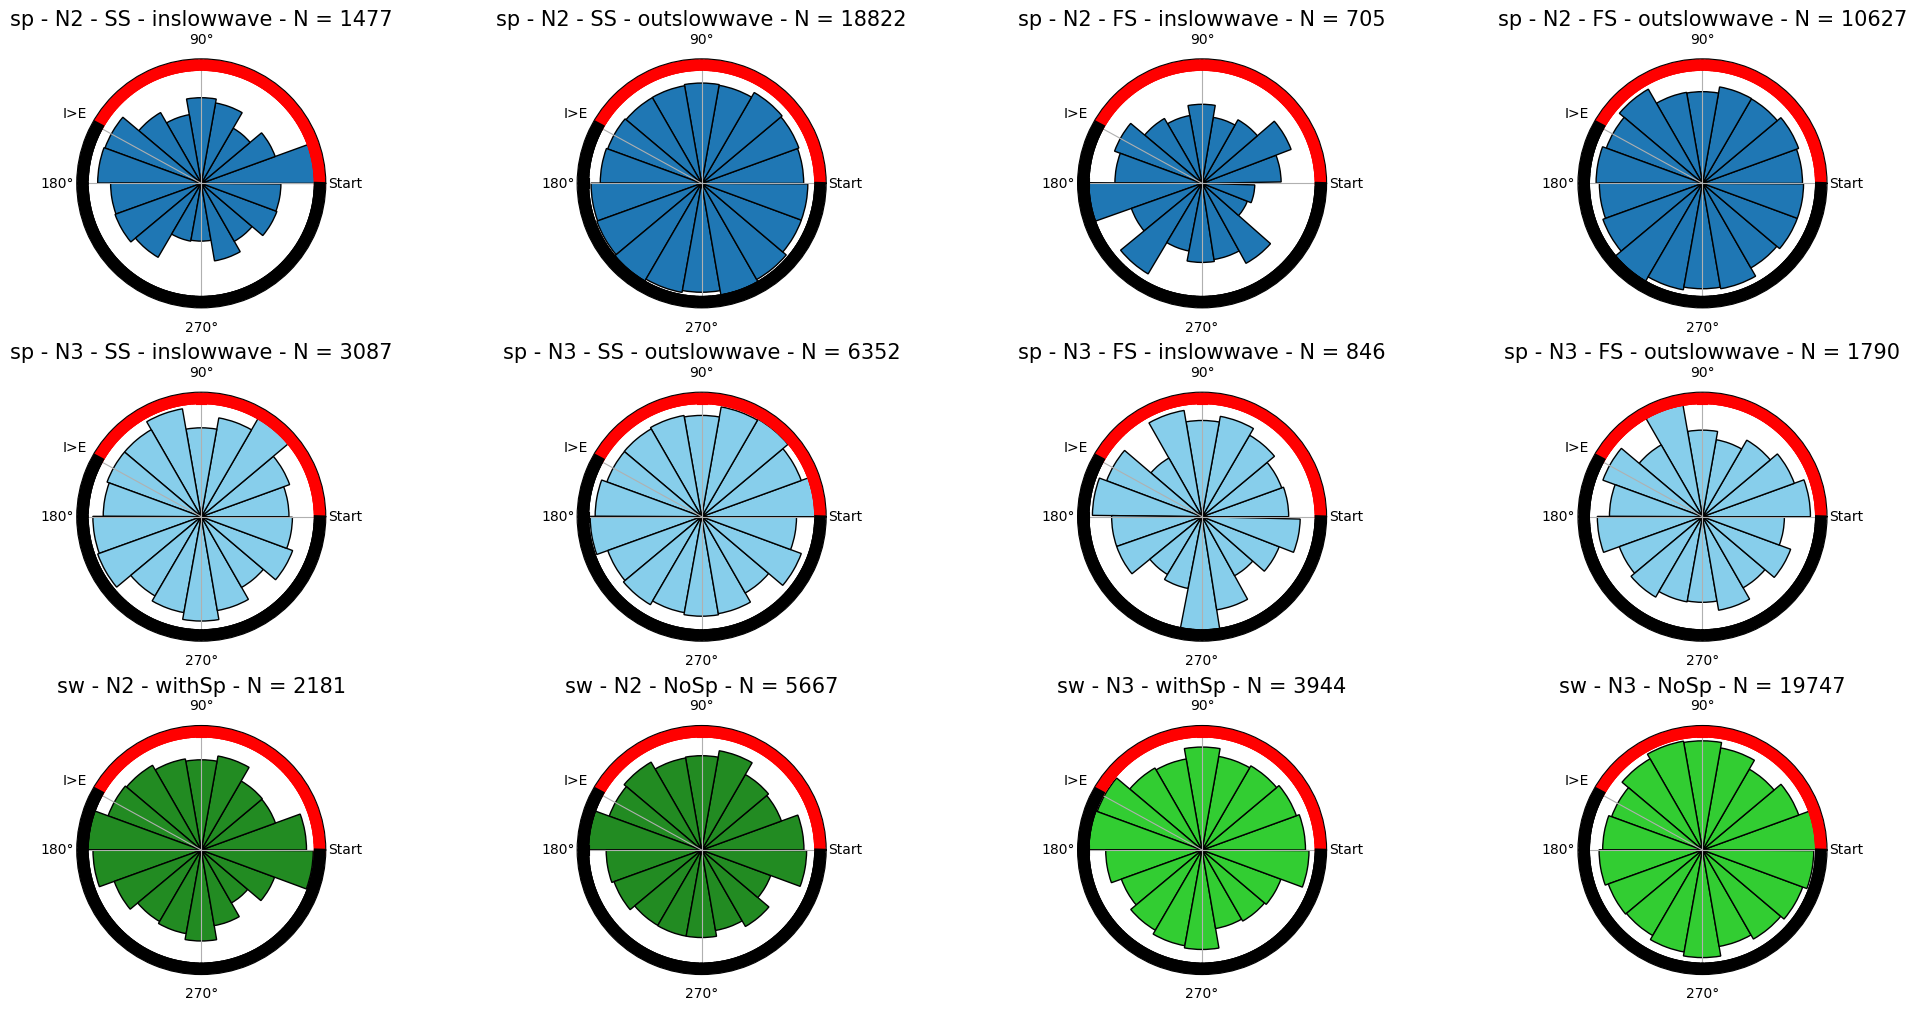

In [24]:
fig, axs = plt.subplots(nrows, ncols, figsize = (20,10), constrained_layout = True, subplot_kw=dict(projection = 'polar'))

for ev in ['sp','sw']:
    ev_title = event_types_titles[ev]
    for stage in ['N2','N3']:
        color = bars_colors[ev][stage]
        if ev == 'sp':
            for speed in ['SS','FS']:
                for cooccur in ['inslowwave','outslowwave']:
                    angles = np.array(pooled_angles[ev][stage][speed][cooccur])
                    N_events = angles.size
                    pos = dict_figure[ev][stage][speed][cooccur]['pos']
                    color = dict_figure[ev][stage][speed][cooccur]['color']
                    ax = axs[pos[0], pos[1]]
                    circular_plot_angles(angles, color, ax=ax)
                    title = f'{ev} - {stage} - {speed} - {cooccur} - N = {N_events}'
                    ax.set_title(title, fontsize = 15, y = 1.1) 
        elif ev == 'sw':
            for cooccur in ['withSp','NoSp']:
                
                angles = np.array(pooled_angles[ev][stage][cooccur])
                N_events = angles.size
                pos = dict_figure[ev][stage][cooccur]['pos']
                
                ax = axs[pos[0], pos[1]]
                color = dict_figure[ev][stage][cooccur]['color']
                circular_plot_angles(angles, color, ax=ax)
                title = f'{ev} - {stage} - {cooccur} - N = {N_events}'
                ax.set_title(title, fontsize = 15, y = 1.1)
                
plt.savefig('../events_coupling_stats/polar_plot_multiple_populations', bbox_inches = 'tight')

In [182]:
subject = 'S10'

In [183]:
data = xr.open_dataarray(f'../preproc/{subject}_reref.nc') # load preprocessed data (lazy load)

In [222]:
freq_sp = (11, 16) # Spindles frequency range. YASA uses a FIR filter (implemented in MNE) with a 1.5Hz transition band, which means that for freq_sp = (12, 15 Hz), the -6 dB points are located at 11.25 and 15.75 Hz.
sp_duration = (0.3, 2.5) # The minimum and maximum duration of the spindles. In secs
sp_min_distance = 500 # If two spindles are closer than min_distance (in ms), they are merged into a single spindles. in milliseconds

# 'rel_pow': Relative power (= power ratio freq_sp / freq_broad).
# 'corr': Moving correlation between original signal and sigma-filtered signal.
# 'rms': Number of standard deviations above the mean of a moving root mean square of sigma-filtered signal.
sp_thresh = {'corr': 0.3, 'rel_pow': 0.01, 'rms': 0.2} # default = 0.65 , 0.2 , 1.5 

In [ ]:
t_start = 14000
wsize = 30
start = t_start
stop = t_start + wsize

sig = data.loc['Fz',start:stop].values

sp = yasa.spindles_detect(sig, sf=srate, freq_sp = freq_sp, duration = sp_duration, min_distance = sp_min_distance, thresh = sp_thresh, verbose = 'error')
if not sp is None:
    sps = sp.summary()
else:
    sps = pd.DataFrame()
    
print(sps.shape)

sig_filt = gh.iirfilt(sig, srate, 1, 30, show= False, order = 10)
sigma = gh.iirfilt(sig, srate, freq_sp[0], freq_sp[1], show= False, order = 1)
t = gh.time_vector(sig, srate)

f, power = gh.morlet_power(sig, srate, 10, 17, 50, 20, amplitude_exponent = 1)

fig, axs = plt.subplots(nrows = 2, figsize = (15,5), sharex = True)
fig.subplots_adjust(hspace = 0)
# ax.plot(t, sig)
ax = axs[0]
ax.plot(t, sig_filt, lw = 0.7)
ax.plot(t, sigma, lw = 0.7)
ax.set_xlim(0, stop - start)

for i, row in sps.iterrows():
    ax.axvline(row['Start'], color = 'tab:orange')
    ax.axvline(row['Peak'], color = 'red')
    ax.axvline(row['End'], color = 'y')
    
ax = axs[1]
ax.pcolormesh(t, f, power)
for i, row in sps.iterrows():
    ax.axvline(row['Start'], color = 'tab:orange')
    ax.axvline(row['Peak'], color = 'red')
    ax.axvline(row['End'], color = 'y')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(6, 13)


In [80]:
corrs = [None, 0.4 , 0.65 , 0.8]
Relpowers = [None , 0.1 , 0.2 , 0.3]
rmss = [None,1, 1.5, 2]

sig = data.loc['Fz',:].values

rows = []
for corr_val in corrs:
    print(corr_val)
    for relpow_val in Relpowers:
        for rms_val in rmss:
            if corr_val is None and relpow_val is None and rms_val is None:
                continue
                
            test_thresh = {'corr':corr_val , 'rel_pow':relpow_val, 'rms':rms_val}
            sp = yasa.spindles_detect(sig, sf=srate, freq_sp = freq_sp, duration = sp_duration, min_distance = sp_min_distance, thresh = test_thresh, verbose = 'critical')
            if sp is None:
                N = 0
            else:
                N = sp.summary().shape[0]
                
            rows.append([corr_val, relpow_val, rms_val, N])
N_sp = pd.DataFrame(rows, columns = ['corr','rel_pow','rms', 'N'])        

None


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.65


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

In [81]:
N_sp

,corr,rel_pow,rms,N
0,NaN,NaN,1.0,3372
1,NaN,NaN,1.5,3228
2,NaN,NaN,2.0,2833
3,NaN,0.1,NaN,3235
4,NaN,0.1,1.0,2633
...,...,...,...,...
58,0.8,0.2,2.0,407
59,0.8,0.3,NaN,327
60,0.8,0.3,1.0,315
61,0.8,0.3,1.5,307


In [112]:
corr_val = np.nan

In [113]:
isinstance(corr_val , float)

True

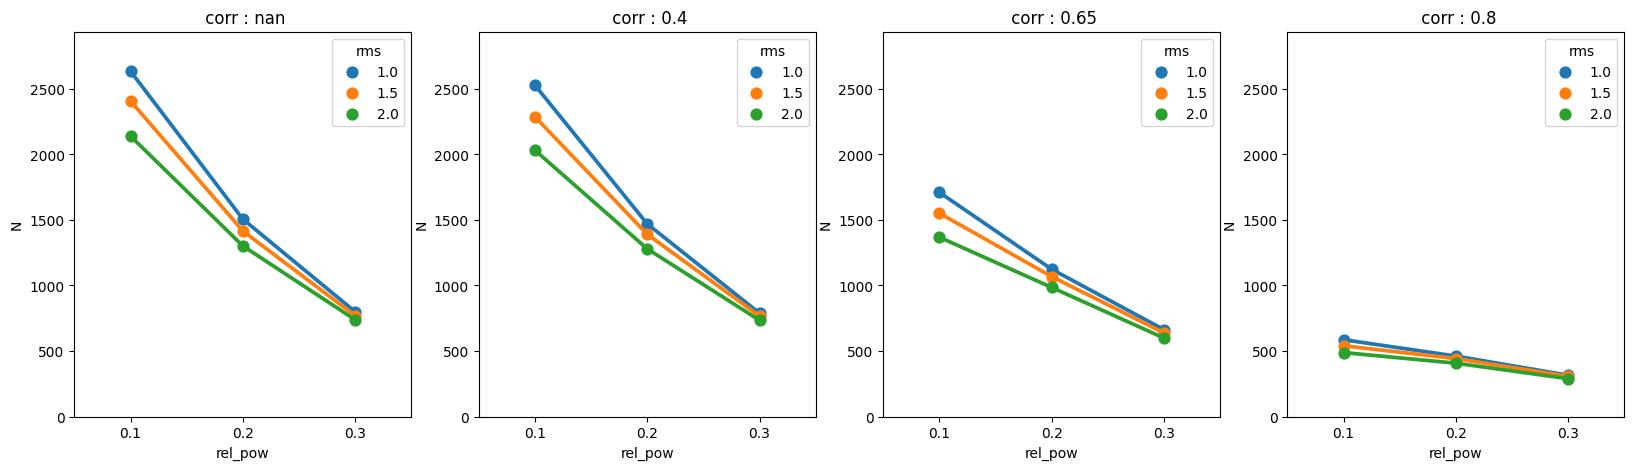

In [118]:
fig, axs = plt.subplots(ncols = N_sp['corr'].unique().size, figsize = (20,5))
for c, corr_val in enumerate(N_sp['corr'].unique()):
    ax = axs[c]
    if not corr_val > 0:    
        df_plot = N_sp[N_sp['corr'].isna()]
    else:
        df_plot = N_sp[N_sp['corr'] == corr_val]
    sns.pointplot(data = df_plot, x = 'rel_pow', y = 'N', hue = 'rms', ax=ax)
    ax.set_ylim(0, N_sp['N'].quantile(0.9))
    ax.set_title(f' corr : {corr_val}')
    

In [7]:
event_types = ['sp','sw'] # types of event = spindles and slow waves
event_types_loads = {'sp':'spindles','sw':'slowwaves'} # label to load
event_types_titles = {'sp':'Spindles','sw':'Slow-Waves'} # clean label for titles
events_tables = {'sp':[],'sw':[]} # prepare lists for event types to pool events from all subjects


In [8]:
for subject in subjects:
    for event_type in event_types:
        events = pd.read_excel(f'../event_detection/{subject}_{event_types_loads[event_type]}_cooccuring.xlsx',index_col = 0) # load events of the subject
        events.insert(0, 'subject', subject) # add subject label at col 0
        events_tables[event_type].append(events) # add the dataframe of the subject to a list

events_df = {event_type:pd.concat(events_tables[event_type]) for event_type in event_types} # pool all dataframes from subjects

In [9]:
events_df['sp']

,subject,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,...,Symmetry,Stage,Channel,IdxChannel,Stage_Letter,in_slowwave,t_vs_NegPeak_sw,t_vs_Start_sw,relative_t_in_sw,Sp_Speed
0,S1,15.160156,15.910156,16.777344,1.617188,76.690796,14.541233,1.512471,0.058145,12.064345,...,0.462651,0,Fp2,0,W,False,NaN,NaN,NaN,SS
1,S1,22.515625,23.867188,24.289062,1.773438,77.093320,15.279712,1.575529,0.067565,11.343477,...,0.760440,0,Fp2,0,W,False,NaN,NaN,NaN,SS
2,S1,29.253906,30.511719,31.453125,2.199219,87.570275,18.601421,1.541746,0.030261,11.523551,...,0.570922,0,Fp2,0,W,False,NaN,NaN,NaN,SS
3,S1,54.046875,54.343750,54.792969,0.746094,52.904826,11.853407,1.707664,0.080165,11.542135,...,0.395833,0,Fp2,0,W,False,NaN,NaN,NaN,SS
4,S1,65.800781,66.808594,67.613281,1.812500,150.039012,24.185366,1.568414,0.036664,12.304631,...,0.554839,0,Fp2,0,W,False,NaN,NaN,NaN,SS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38082,S20,31972.167969,31972.941406,31973.554688,1.386719,38.387404,9.232534,0.998247,0.056149,13.616453,...,0.556180,2,O2,10,N2,False,NaN,NaN,NaN,FS
38083,S20,31976.890625,31977.757812,31978.816406,1.925781,52.581370,11.484902,0.916943,0.033904,13.251744,...,0.449393,2,O2,10,N2,False,NaN,NaN,NaN,FS
38084,S20,31981.535156,31981.707031,31982.296875,0.761719,45.897443,9.804117,1.116000,0.043475,13.332457,...,0.224490,2,O2,10,N2,False,NaN,NaN,NaN,FS
38085,S20,31989.941406,31990.800781,31991.476562,1.535156,47.990464,11.386426,1.031188,0.049829,13.975597,...,0.558376,2,O2,10,N2,False,NaN,NaN,NaN,FS
